# Face Detection System for Digital Cameras

## Introduction
This notebook implements a robust and lightweight face detection system designed specifically for embedded digital camera applications. The system is engineered to operate efficiently on resource-constrained hardware (Cortex-A55–class SoC) while maintaining real-time performance and high accuracy for face detection tasks.

## Project Overview
Our face detection system employs a two-stage cascade approach to efficiently identify faces in images:

1. **Stage 1 - Fast Rejector**: Uses Local Binary Patterns (LBP) with a Random Forest classifier to quickly eliminate most non-face regions with minimal computational cost
2. **Stage 2 - Precise Verifier**: Applies Histogram of Oriented Gradients (HOG) with a Linear SVM to accurately verify face candidates that passed the first stage

### Implementation Pipeline
1. **Dataset Preparation**: Processes training, validation, and test image sets with face annotations
2. **Feature Extraction**: Implements LBP and HOG feature extraction for facial pattern recognition
3. **Model Training**: Trains and optimizes Random Forest and SVM classifiers with hyperparameter tuning
4. **Face Detection**: Applies the trained models using a sliding window approach with scale pyramid
5. **Post-Processing**: Implements non-maximum suppression to eliminate redundant detections
6. **Performance Evaluation**: Measures accuracy, precision, recall, and computational efficiency

This notebook serves as a comprehensive implementation of the complete face detection pipeline, from data preparation to final model evaluation.

## 1. Module Imports

This section imports all necessary libraries for implementing our two-stage cascade face detection system. Each library serves a specific purpose in our pipeline:

### Core Libraries
- **NumPy**: Provides efficient array operations for image manipulation and feature extraction
- **OpenCV (cv2)**: Handles image I/O, preprocessing, and includes the DNN face detector for initial dataset preparation
- **scikit-learn**: Implements our machine learning models (RandomForest for LBP stage, LinearSVC for HOG stage)
- **scikit-image**: Provides implementations of our feature extractors (HOG and LBP)

### Feature Extraction Libraries
- **skimage.feature.local_binary_pattern**: Implements LBP features for our first-stage fast rejector
- **skimage.feature.hog**: Implements Histogram of Oriented Gradients for our second-stage precise verifier
- **sklearn.decomposition.PCA**: Optional dimensionality reduction for feature compression

### Model Training & Evaluation
- **sklearn.model_selection**: Provides train/test splitting and hyperparameter tuning utilities
- **sklearn.ensemble.RandomForestClassifier**: Our first-stage classifier using LBP features
- **sklearn.svm.LinearSVC**: Our second-stage classifier using HOG features

### Visualization & Analysis
- **matplotlib.pyplot**: Creates visualizations of detections, feature importance, and performance metrics
- **pandas**: Used for organizing and analyzing experimental results

The system is designed for embedded deployment on resource-constrained hardware (Cortex-A55 class SoC), requiring careful optimization of the pipeline to achieve real-time performance within a 1W power envelope.

In [1]:
!sudo apt-get update
!sudo apt-get install -y libgl1


Hit:1 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:2 https://dl.yarnpkg.com/debian stable InRelease                           
Hit:3 https://packages.microsoft.com/repos/microsoft-ubuntu-noble-prod noble InRelease
Hit:4 https://repo.anaconda.com/pkgs/misc/debrepo/conda stable InRelease       
Get:5 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]
Get:6 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]
Get:7 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:8 http://archive.ubuntu.com/ubuntu noble-updates/main amd64 Packages [1665 kB]
Get:9 http://archive.ubuntu.com/ubuntu noble-updates/universe amd64 Packages [1454 kB]
Fetched 3497 kB in 1s (2721 kB/s)                         
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.7.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
%pip install --upgrade pip
%pip install numpy==1.26.3
%pip install scipy==1.11.3
!apt-get update
!apt-get install -y libgl1
!apt-get update && apt-get install -y opencv-data


%pip install opencv-python==4.8.1.78
%pip install scikit-learn==1.3.0
%pip install scikit-image==0.21.0
%pip install matplotlib pandas


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import cv2
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import skimage  
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import os
from matplotlib.patches import Rectangle
from tqdm import tqdm
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib
import time


print(f"NumPy version: {np.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"scikit-learn version: {sklearn_version}")
print(f"scikit-image version: {skimage.__version__}")
print("All modules imported successfully")

NumPy version: 1.26.3
OpenCV version: 4.8.1
scikit-learn version: 1.3.0
scikit-image version: 0.21.0
All modules imported successfully


# 2. Dataset Loading and Exploration

This section handles the acquisition, preprocessing, and exploration of our training, validation, and test datasets. The workflow includes:

## Dataset Acquisition
- **Local Datasets**: We use three separate Selfie datasets stored in `/Selfie_training`, `/Selfie_validation`, and `/Selfie_test` directories
- **Image Format**: Standard JPEG/PNG images with varying resolutions, representing real-world selfie scenarios
- **Face Detection**: We employ a pre-trained DNN face detector from OpenCV to identify faces in the dataset images

## Preprocessing Pipeline
1. **DNN Face Detection**: For each image, we apply the DNN detector to locate faces with high precision
2. **Quality Filtering**: Images without detected faces are removed from the dataset to ensure all training samples contain valid face regions
3. **RGB Conversion**: BGR images from OpenCV are converted to RGB for consistent visualization and processing

## Dataset Statistics & Visualization
- **Distribution Analysis**: We calculate and visualize key statistics about image dimensions, face counts, and face sizes
- **Sample Visualization**: Representative images with bounding box annotations are displayed to verify the quality of face detection

## Dataset Structure
We organize the data into a custom `SelfieDataset` class that provides a consistent interface for the rest of our pipeline, maintaining compatibility with standard image processing workflows.


This section loads OpenCV's pre-trained face detection model that will be used as a reference for our dataset. The code:

1. Searches common system locations for the model files
2. Downloads them if not found
3. Loads the DNN model into memory

This pre-trained model will help us identify faces in our dataset images to train our own lightweight detector.

In [4]:
# Loading pre-trained model DNN to identify faces in the dataset.

possible_paths = [
    '/usr/share/opencv4/dnn_face_detector',
    '/usr/local/share/opencv4/dnn_face_detector',
    '/usr/share/opencv/dnn_face_detector',
    '/usr/local/share/opencv/dnn_face_detector'
]

model_found = False
for base_path in possible_paths:
    if os.path.exists(base_path):
        prototxt_path = os.path.join(base_path, 'deploy.prototxt')
        model_path = os.path.join(base_path, 'res10_300x300_ssd_iter_140000.caffemodel')
        
        if os.path.exists(prototxt_path) and os.path.exists(model_path):
            model_found = True
            print(f"DNN model found in: {base_path}")
            break

# Fallback if model not found
if not model_found:
    # Create directory if needed
    MODEL_DIR = '/workspaces/Face-detection-for-digital-camera/models'
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    
    prototxt_path = os.path.join(MODEL_DIR, 'deploy.prototxt')
    model_path = os.path.join(MODEL_DIR, 'res10_300x300_ssd_iter_140000.caffemodel')
    
    # Download the model if needed
    if not os.path.exists(prototxt_path):
        print("Download of prototxt file...")
        !wget -q -O {prototxt_path} https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
    
    if not os.path.exists(model_path):
        print("Dolownad Caffe model...")
        !wget -q -O {model_path} https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

#Model Loading
face_net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)
print("DNN model correctly downloaded!")


DNN model correctly downloaded!


Face Detection Function

This function implements face detection using OpenCV's DNN model. It:

- Creates a 300×300 normalized blob from the input image
- Feeds the blob into the neural network
- Processes detections, extracting bounding boxes for faces above the confidence threshold
- Returns a list of face coordinates as (x, y, width, height) tuples


In [5]:
def detect_faces_dnn(image, confidence_threshold=0.5):
    """
    Detect faces in an image usign DNN

    Args:
        image: Immagine BGR (from cv2.imread)
        confidence_threshold
        
    Returns:
        Lista of tuple (x, y, w, h) for the bounding box of the faces
    """
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), 
                                [104, 117, 123], False, False)
    
    face_net.setInput(blob)
    detections = face_net.forward()
    
    # Bounding box extraction
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(w, x2)
            y2 = min(h, y2)
            
            faces.append((x1, y1, x2-x1, y2-y1))
    
    return faces

Dataset Loading Function:

This function processes images from a directory, detecting faces with the DNN model:

- Scans for image files (PNG, JPG, JPEG)
- Loads each image and converts to RGB
- Detects faces using the pre-trained DNN model
- Keeps only images with at least one face
- Returns arrays of processed images, face coordinates, and file lists

In [6]:
def load_dataset_with_face_detection(directory):
    all_images = []
    all_faces = []
    kept_files = []
    removed_files = []
    
    print(f"Images elaboration in {directory} with DNN...")
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in tqdm(image_files):
        file_path = os.path.join(directory, filename)
        try:
            
            img = cv2.imread(file_path)
            if img is None:
                removed_files.append(filename)
                continue
                
           
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            
            faces = detect_faces_dnn(img)
            
            if len(faces) > 0:
                
                all_images.append(img_rgb)
                all_faces.append(faces)
                kept_files.append(filename)
            else:
                removed_files.append(filename)
        except Exception as e:
            print(f"Errore nell'elaborazione di {filename}: {e}")
            removed_files.append(filename)
    
    return all_images, all_faces, kept_files, removed_files

The next function loads images from a directory, detects faces using a DNN model, and filters out images without faces. 

It returns lists of RGB images, detected face bounding boxes, kept filenames, and removed filenames.

In [7]:
# Function to load images and detect faces
def load_dataset_with_face_detection(directory):
    all_images = []
    all_faces = []
    kept_files = []
    removed_files = []
    
    print(f"Processing images in {directory} with DNN detector...")
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in tqdm(image_files):
        file_path = os.path.join(directory, filename)
        try:
            # Load and convert image to RGB
            img = cv2.imread(file_path)
            if img is None:
                removed_files.append(filename)
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect faces using DNN 
            faces = detect_faces_dnn(img)
            
            if len(faces) > 0:

                all_images.append(img_rgb)
                all_faces.append(faces)
                kept_files.append(filename)
            else:
                removed_files.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            removed_files.append(filename)
    
    return all_images, all_faces, kept_files, removed_files


Detailed Sample Analysis and Visualization

This cell provides in-depth visual analysis of a specific sample image with face detections. It:

1. Selects a specific sample image (index 10) from the training set
2. Displays detailed information about the image (dimensions and number of detected faces)
3. Creates a 2×2 visualization layout showing:
	- The original unmodified image
	- The same image with face bounding boxes and numerical labels
	- A close-up crop of the first detected face
	- A close-up crop of the second face (if multiple faces are present)

This visualization helps verify the quality of face detection by showing both the overall context.

Accessing and exploring local Selfie datasets...
Processing images in /workspaces/Face-detection-for-digital-camera/Selfie_training with DNN detector...


  2%|▏         | 131/8183 [00:11<13:14, 10.14it/s]

100%|██████████| 8183/8183 [03:38<00:00, 37.38it/s]


Processing images in /workspaces/Face-detection-for-digital-camera/Selfie_validation with DNN detector...


100%|██████████| 3931/3931 [01:46<00:00, 36.94it/s]


Processing images in /workspaces/Face-detection-for-digital-camera/Selfie_test with DNN detector...


100%|██████████| 3931/3931 [01:43<00:00, 37.90it/s]



--- Dataset Statistics ---
Training images - Initial: 8183, Kept: 7784, Removed: 399
Validation images - Initial: 3931, Kept: 3773, Removed: 158
Test images - Initial: 3931, Kept: 3771, Removed: 160

Displaying sample images with detected faces...


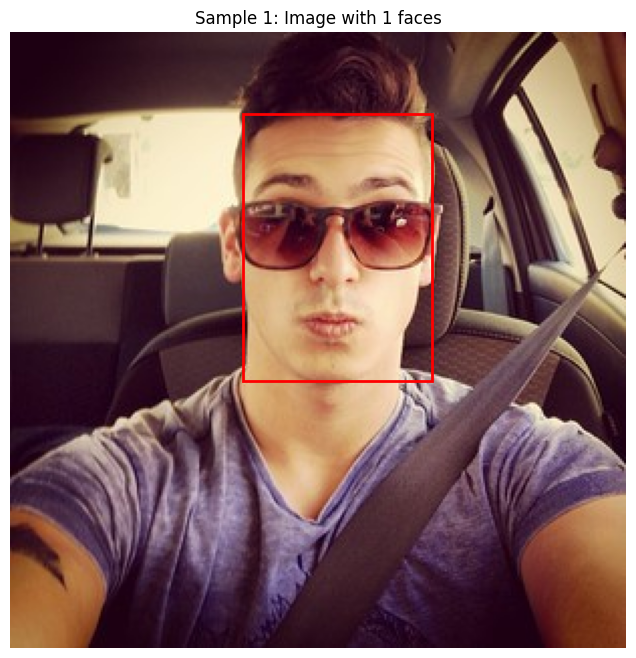

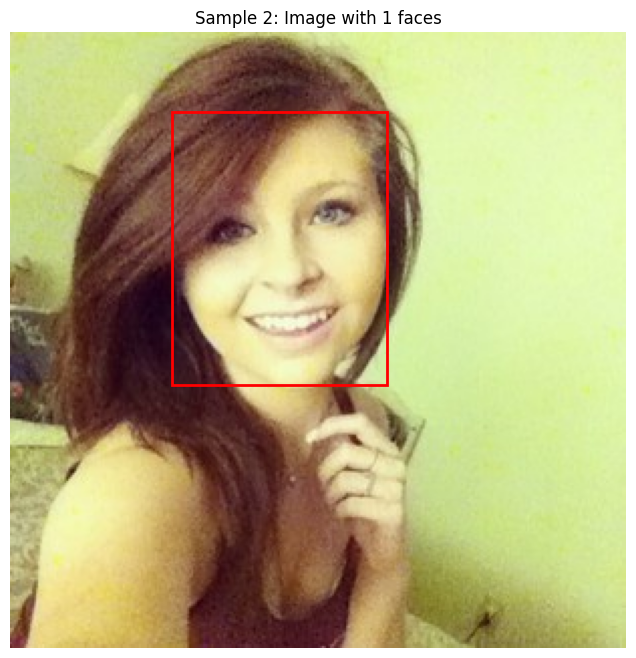

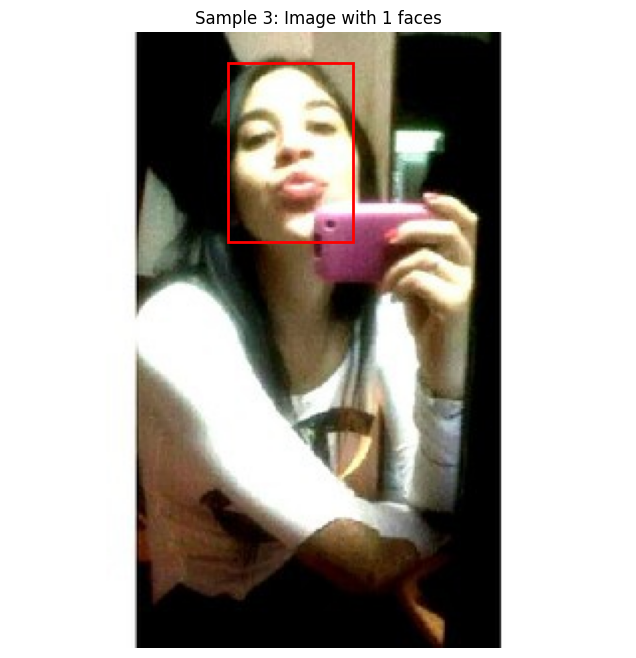


# Detailed Sample Exploration
Sample 10 information:
Image shape: (306, 306, 3)
Number of faces: 1


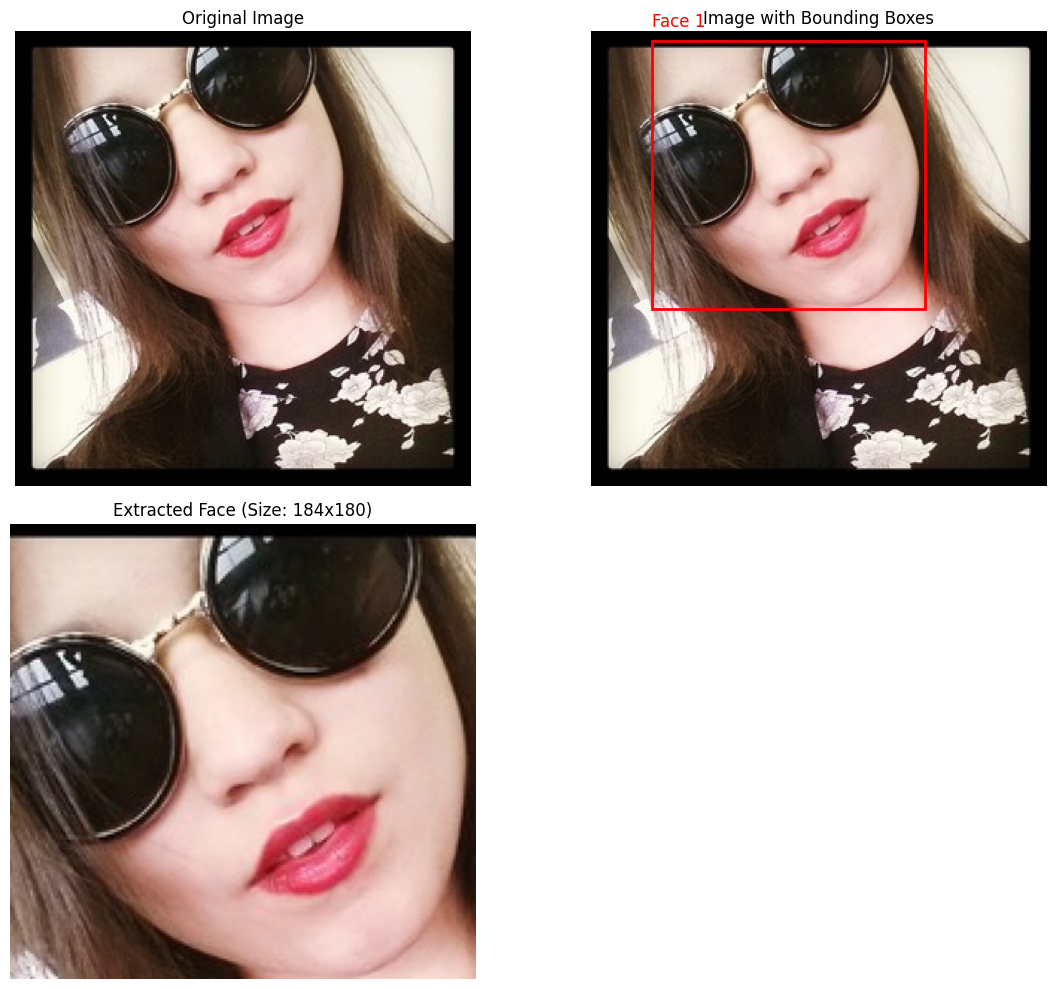

In [8]:
# 2. Dataset Access and Exploration - Using Local Selfie Datasets
print("Accessing and exploring local Selfie datasets...")

# Define paths to the datasets
train_dir = '/workspaces/Face-detection-for-digital-camera/Selfie_training'
val_dir = '/workspaces/Face-detection-for-digital-camera/Selfie_validation'
test_dir = '/workspaces/Face-detection-for-digital-camera/Selfie_test'

# Process all datasets
train_images, train_faces, train_kept, train_removed = load_dataset_with_face_detection(train_dir)
val_images, val_faces, val_kept, val_removed = load_dataset_with_face_detection(val_dir)

if test_dir:
    test_images, test_faces, test_kept, test_removed = load_dataset_with_face_detection(test_dir)

# Print dataset statistics
print("\n--- Dataset Statistics ---")
print(f"Training images - Initial: {len(train_kept) + len(train_removed)}, Kept: {len(train_kept)}, Removed: {len(train_removed)}")
print(f"Validation images - Initial: {len(val_kept) + len(val_removed)}, Kept: {len(val_kept)}, Removed: {len(val_removed)}")
if test_dir:
    print(f"Test images - Initial: {len(test_kept) + len(test_removed)}, Kept: {len(test_kept)}, Removed: {len(test_removed)}")

# Display a few sample images with face bounding boxes
print("\nDisplaying sample images with detected faces...")
for idx in range(min(3, len(train_images))):
    plt.figure(figsize=(10, 8))
    plt.imshow(train_images[idx])
    
    # Draw bounding boxes
    for (x, y, w, h) in train_faces[idx]:
        rect = Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    
    plt.title(f"Sample {idx+1}: Image with {len(train_faces[idx])} faces")
    plt.axis('off')
    plt.show()

# Detailed example of a specific sample with face detections
if len(train_images) > 10:
    sample_idx = 10
    print("\n# Detailed Sample Exploration")
    
    print(f"Sample {sample_idx} information:")
    print(f"Image shape: {train_images[sample_idx].shape}")
    print(f"Number of faces: {len(train_faces[sample_idx])}")
    
    # Plot original image and images with bounding boxes
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(train_images[sample_idx])
    plt.title("Original Image")
    plt.axis('off')
    
    # Plot image with bounding boxes
    plt.subplot(2, 2, 2)
    plt.imshow(train_images[sample_idx])
    for i, (x, y, w, h) in enumerate(train_faces[sample_idx]):
        rect = Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x, y-10, f"Face {i+1}", color='red', fontsize=12)
    plt.title("Image with Bounding Boxes")
    plt.axis('off')
    
    # Extract and display face crops
    if len(train_faces[sample_idx]) > 0:
        plt.subplot(2, 2, 3)

        x, y, w, h = train_faces[sample_idx][0]

        face = train_images[sample_idx][y:y+h, x:x+w]
        plt.imshow(face)
        plt.title(f"Extracted Face (Size: {w}x{h})")
        plt.axis('off')
        
        # If there are multiple faces, show another one
        if len(train_faces[sample_idx]) > 1:
            plt.subplot(2, 2, 4)
            x, y, w, h = train_faces[sample_idx][1]

            face = train_images[sample_idx][y:y+h, x:x+w]
            plt.imshow(face)
            plt.title(f"Another Face (Size: {w}x{h})")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Dataset Statistics Analysis

In [9]:
# Calculate dataset statistics
print("\nDataset Statistics:")

# Calculate image dimensions and face sizes
heights = []
widths = []
face_widths = []
face_heights = []
faces_per_image = []

# Get image statistics from training set
for idx in range(min(100, len(train_images))):
    img = train_images[idx]
    heights.append(img.shape[0])
    widths.append(img.shape[1])
    faces_per_image.append(len(train_faces[idx]))
    
    # Collect face dimensions
    for (x, y, w, h) in train_faces[idx]:
        face_widths.append(w)
        face_heights.append(h)

# Calculate statistics
avg_faces = sum(faces_per_image) / len(faces_per_image)
print(f"Average faces per image (first {len(faces_per_image)} images): {avg_faces:.2f}")
print("\nImage dimension statistics:")
print(f"Average height: {sum(heights)/len(heights):.2f} pixels")
print(f"Average width: {sum(widths)/len(widths):.2f} pixels")
print(f"Height range: {min(heights)} to {max(heights)} pixels")
print(f"Width range: {min(widths)} to {max(widths)} pixels")

# Print face size statistics
if face_widths:
    print("\nFace size statistics:")
    print(f"Average face width: {sum(face_widths)/len(face_widths):.2f} pixels")
    print(f"Average face height: {sum(face_heights)/len(face_heights):.2f} pixels")
    print(f"Face width range: {min(face_widths)} to {max(face_widths)} pixels")
    print(f"Face height range: {min(face_heights)} to {max(face_heights)} pixels")
else:
    print("\nNo face data available in the analyzed samples")


Dataset Statistics:
Average faces per image (first 100 images): 1.01

Image dimension statistics:
Average height: 306.00 pixels
Average width: 306.00 pixels
Height range: 306 to 306 pixels
Width range: 306 to 306 pixels

Face size statistics:
Average face width: 126.28 pixels
Average face height: 162.08 pixels
Face width range: 25 to 227 pixels
Face height range: 45 to 278 pixels


##### Dataset Structure and Organization

This cell implements the SelfieDataset class and organizes the processed data into a standardized format.

1. Creates a custom dataset class with:

	- A simple constructor that stores images and bounding boxes
	- A __len__ method to get dataset size
	- A numpy method for compatibility with operations requiring numpy arrays

2. Converts the image and face detection data into compatible formats.
3. Creates output documentation of the dataset processing.

In [10]:
class SelfieDataset:
    def __init__(self, images, boxes):
        self.images = images
        self.boxes = boxes
        
    def __len__(self):
        return len(self.images)
        
    def numpy(self):
        return self
        
# Convert to numpy arrays with the expected format for compatibility
ds_train = SelfieDataset(train_images, [np.array([(x, y, w, h) for (x, y, w, h) in faces]) for faces in train_faces])
ds_val = SelfieDataset(val_images, [np.array([(x, y, w, h) for (x, y, w, h) in faces]) for faces in val_faces])
if test_dir:
    ds_test = SelfieDataset(test_images, [np.array([(x, y, w, h) for (x, y, w, h) in faces]) for faces in test_faces])
else:
    ds_test = None

# Save the lists of kept and removed files
with open('dataset_processing_results.txt', 'w') as f:
    f.write("--- Dataset Processing Results ---\n\n")
    f.write(f"Training images - Initial: {len(train_kept) + len(train_removed)}, Kept: {len(train_kept)}, Removed: {len(train_removed)}\n")
    f.write(f"Validation images - Initial: {len(val_kept) + len(val_removed)}, Kept: {len(val_kept)}, Removed: {len(val_removed)}\n")
    if test_dir:
        f.write(f"Test images - Initial: {len(test_kept) + len(test_removed)}, Kept: {len(test_kept)}, Removed: {len(test_removed)}\n")
    
    f.write("\nRemoved training images (no faces detected):\n")
    for filename in train_removed:
        f.write(f"- {filename}\n")
    
    f.write("\nRemoved validation images (no faces detected):\n")
    for filename in val_removed:
        f.write(f"- {filename}\n")
    
    if test_dir:
        f.write("\nRemoved test images (no faces detected):\n")
        for filename in test_removed:
            f.write(f"- {filename}\n")

print(f"\nSaved list of kept and removed files to 'dataset_processing_results.txt'")
print("\nDataset preparation complete!")


Saved list of kept and removed files to 'dataset_processing_results.txt'

Dataset preparation complete!


# 3. Dataset Construction (Patch Extraction & Split)

This section implements the crucial process of creating a high-quality training dataset for our cascade face detector. The implementation follows a patch extraction strategy to ensure robust model training:

## Patch Extraction Workflow

### Positive Sample Extraction
- **Input**: Face images with bounding box annotations from the previous DNN detection stage
- **Patch Size**: Fixed 64×64 pixel windows containing face regions
- **IoU Threshold**: Patches with IoU ≥ 0.7 against a detected face box are considered positive
- **Multi-Strategy Approach**:
  1. **Center-Aligned Patches**: Extract patches perfectly centered on detected faces
  2. **Proportional Resizing**: Maintain aspect ratio while resizing face regions to fit the 64×64 window
  3. **Controlled Jittering**: Generate additional positive samples with slight random variations (±10% offset) for robustness

### Negative Sample Extraction
- **Sampling Criteria**: Windows at least 200 pixels away from any face region
- **Balanced Dataset**: Equal number of positive and negative samples for unbiased training
- **Strategic Sampling**: Limited number of negative samples per image to ensure diversity
- **Quality Control**: Verification checks to ensure extracted patches are valid (proper dimensions and content)

## Dataset Splitting and Organization

- **Training Set**: Up to 8,000 face patches and an equal number of non-face patches
- **Validation Set**: Up to 2,000 face/non-face patch pairs for hyperparameter tuning
- **Test Set**: Up to 2,000 face/non-face patch pairs for final evaluation
- **Randomization**: All data is shuffled while preserving face/non-face labels

## Data Persistence
- **Storage Format**: NumPy compressed archive (.npz) for efficient storage and loading
- **Saved Data**: Raw image patches and corresponding binary labels (1=face, 0=non-face)
- **Size Optimization**: Grayscale representation to reduce memory footprint

This carefully constructed dataset provides the foundation for training both stages of our cascade classifier: the RandomForest using LBP features (fast rejector) and the LinearSVC using HOG features (precise verifier).

##### IoU Calculation Function

This function calculates the Intersection over Union (IoU) metric between two bounding boxes.

IoU = intersection area / (sum of individual areas - intersection area)

In [11]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


##### Positive and Negative Patch Extraction Functions
This cell implements two functions for extracting training patches:

extract_improved_positive_patches: Extracts face patches from the dataset using three complementary strategies:

- Centered patches that place faces in the middle of a fixed-size window
- Proportionally resized face regions that maintain aspect ratio
- Jittered patches with small random variations for training robustness

extract_improved_negative_patches: Extracts non-face patches with careful constraints:

- Maintains minimum distance from any face region (200 pixels)
- Limits patches per image to ensure diversity
- Implements quality checks for valid dimensions

Both functions use grayscale conversion for consistency and include error handling to manage potential extraction issues. The patch size is fixed at 64×64 pixels, which balances detail preservation with computational efficiency.

In [12]:
def extract_positive_patches(dataset, patch_size=64, pos_iou_thresh=0.7, patches_per_face=5):
    """
    Patch extraction based on DNN bounding boxes
    """
    X_pos = []
    
    for idx in tqdm(range(len(dataset))):
        image = dataset.images[idx]
        boxes = dataset.boxes[idx]
        h, w = image.shape[:2]
        
        # Grayscale conversion
        if len(image.shape) == 3:
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            image_gray = image
        
        for box in boxes:
            x, y, bw, bh = [int(v) for v in box]

            # Calculate the center of the face
            center_x = x + bw // 2
            center_y = y + bh // 2

            # Create a patch centered on the face
            half_size = patch_size // 2
            center_x_patch = max(half_size, min(w - half_size, center_x))
            center_y_patch = max(half_size, min(h - half_size, center_y))

            # Extract the patch
            patch_x = center_x_patch - half_size
            patch_y = center_y_patch - half_size
            patch = image_gray[patch_y:patch_y+patch_size, patch_x:patch_x+patch_size]
            
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                X_pos.append(patch)

            #Resize the exact face (maintaining proportions)
            face = image_gray[y:y+bh, x:x+bw]
            if face.shape[0] > 0 and face.shape[1] > 0:

                scale = max(patch_size / face.shape[0], patch_size / face.shape[1])
                new_h, new_w = int(face.shape[0] * scale), int(face.shape[1] * scale)
                
                if new_h > 0 and new_w > 0:
                    face_resized = cv2.resize(face, (new_w, new_h))
                    
                    # Center the resized face in a patch
                    patch_face = np.zeros((patch_size, patch_size), dtype=face_resized.dtype)
                    
                    # Calculate where to place the resized face
                    start_y = max(0, (patch_size - new_h) // 2)
                    start_x = max(0, (patch_size - new_w) // 2)
                    
                    # Ensure the resized face fits within the patch
                    end_y = min(start_y + new_h, patch_size)
                    end_x = min(start_x + new_w, patch_size)
                    face_h = end_y - start_y
                    face_w = end_x - start_x
                    
                    if face_h > 0 and face_w > 0:
                        patch_face[start_y:end_y, start_x:end_x] = face_resized[:face_h, :face_w]
                        X_pos.append(patch_face)
            
            # Jitter surrounding the original box for variability
            for _ in range(patches_per_face - 2):  # -2 because we have already added 2 patches
                # Light jitter
                dx = np.random.randint(-bw//10, bw//10 + 1)
                dy = np.random.randint(-bh//10, bh//10 + 1)
                dw = np.random.randint(-bw//10, bw//10 + 1)
                dh = np.random.randint(-bh//10, bh//10 + 1)

                # Apply jitter to the box
                jit_x = max(0, x + dx)
                jit_y = max(0, y + dy)
                jit_w = max(10, min(w - jit_x, bw + dw))
                jit_h = max(10, min(h - jit_y, bh + dh))
                
                # Extract and resize
                if jit_w > 0 and jit_h > 0:
                    try:
                        face_jit = image_gray[jit_y:jit_y+jit_h, jit_x:jit_x+jit_w]
                        if face_jit.shape[0] > 0 and face_jit.shape[1] > 0:
                            face_jit_resized = cv2.resize(face_jit, (patch_size, patch_size))
                            X_pos.append(face_jit_resized)
                    except Exception as e:
                        print(f"Errore nell'estrazione del patch con jitter: {e}")
    
    return np.array(X_pos)


def extract_negative_patches(dataset, target_count, patch_size=64, neg_dist_thresh=200):
    """
    Extract negative patches with a minimum distance from faces
    """
    X_neg = []
    
    num_images = len(dataset)
    
    # Extract balanced negative patches
    neg_patches_extracted = 0
    for idx in tqdm(range(num_images)):
        # If we have already extracted enough negative patches, stop
        if neg_patches_extracted >= target_count:
            break
            
        image = dataset.images[idx]
        boxes = dataset.boxes[idx]
        h, w = image.shape[:2]
        
        if len(image.shape) == 3:
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            image_gray = image

        # Calculate how many negative patches to extract from this image
        # Limit to avoid extracting too many patches from a single image
        neg_per_image = min(5, target_count - neg_patches_extracted)
        
        neg_count = 0
        attempts = 0
        while neg_count < neg_per_image and attempts < 50:
            nx = np.random.randint(0, w-patch_size)
            ny = np.random.randint(0, h-patch_size)
            patch_box = [nx, ny, patch_size, patch_size]

            # Calculate the minimum distance from each face box
            distances = [np.sqrt((nx-x)**2 + (ny-y_box)**2) for x, y_box, bw, bh in boxes]
            min_dist = min(distances) if distances else float('inf')
            
            if min_dist >= neg_dist_thresh:
                try:
                    patch = image_gray[ny:ny+patch_size, nx:nx+patch_size]
                    if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                        X_neg.append(patch)
                        neg_count += 1
                        neg_patches_extracted += 1

                        # If we have reached the target, stop
                        if neg_patches_extracted >= target_count:
                            break
                except Exception as e:
                    print(f"Errore nell'estrazione di un patch negativo: {e}")
            attempts += 1
    
    return np.array(X_neg)


In [13]:
def extract_patches_from_dataset(dataset, limit=None, PATCH_SIZE = 64, POS_IOU_THRESH = 0.7, POS_PATCHES_PER_FACE = 5, NEG_DIST_THRESH = 200):
    """
    Extracts balanced positive and negative patches from the dataset
    """
    # Extract positive patches
    X_pos = extract_positive_patches(
        dataset, 
        patch_size=PATCH_SIZE, 
        pos_iou_thresh=POS_IOU_THRESH, 
        patches_per_face=POS_PATCHES_PER_FACE
    )

    # Limit the number of positive patches if requested
    if limit is not None and len(X_pos) > limit:
        indices = np.random.choice(len(X_pos), limit, replace=False)
        X_pos = X_pos[indices]

    # Calculate how many negative patches to extract for a balanced dataset
    target_neg_patches = len(X_pos)
    print(f"Found {len(X_pos)} positive patches. Generating {target_neg_patches} negative patches to balance the dataset...")

    # Extract negative patches
    X_neg = extract_negative_patches(
        dataset, 
        target_count=target_neg_patches, 
        patch_size=PATCH_SIZE, 
        neg_dist_thresh=NEG_DIST_THRESH
    )
    
    return X_pos, X_neg

##### Dataset Construction (Patch Extraction & Balanced Dataset)
This cell implements the main dataset construction process by:

1. Configuring and displaying key extraction parameters.
2. Extracting balanced face and non-face patches:
	- Training dataset: Up to 8,000 samples of each class
	- Validation dataset: Up to 2,000 samples of each class
	- Test dataset: Up to 2,000 samples of each class
3. Creating balanced datasets with labels:
	- Positive samples (faces) labeled as 1
	- Negative samples (non-faces) labeled as 0
4. Randomizing the data:
	- Shuffling both images and labels together
5. Preserving the train/validation/test split

This preprocessing pipeline ensures balanced, diverse data for training the face detection cascade.

In [14]:
# Extraction parameters
PATCH_SIZE = 64
POS_IOU_THRESH = 0.7 
NEG_DIST_THRESH = 200
POS_PATCHES_PER_FACE = 5

print("Patch extraction configuration:")
print(f"- Patch size: {PATCH_SIZE}x{PATCH_SIZE} pixels")
print(f"- IoU threshold for positive patches: {POS_IOU_THRESH}")
print(f"- Minimum distance for negative patches: {NEG_DIST_THRESH} pixels")
print(f"- Positive patches per face: {POS_PATCHES_PER_FACE}")

# Extract patch 
print("\nTraining dataset patch extraction...")
X_train_pos, X_train_neg = extract_patches_from_dataset(ds_train, limit=8000, PATCH_SIZE=PATCH_SIZE, POS_IOU_THRESH=POS_IOU_THRESH, POS_PATCHES_PER_FACE=POS_PATCHES_PER_FACE, NEG_DIST_THRESH=NEG_DIST_THRESH)

print("\nValidation dataset patch extraction...")
X_val_pos, X_val_neg = extract_patches_from_dataset(ds_val, limit=2000, PATCH_SIZE=PATCH_SIZE, POS_IOU_THRESH=POS_IOU_THRESH, POS_PATCHES_PER_FACE=POS_PATCHES_PER_FACE, NEG_DIST_THRESH=NEG_DIST_THRESH)

print("\nTest dataset patch extraction...")
X_test_pos, X_test_neg = extract_patches_from_dataset(ds_test, limit=2000, PATCH_SIZE=PATCH_SIZE, POS_IOU_THRESH=POS_IOU_THRESH, POS_PATCHES_PER_FACE=POS_PATCHES_PER_FACE, NEG_DIST_THRESH=NEG_DIST_THRESH)

# Balanced dataset construction with labels
X_train = np.vstack([X_train_pos, X_train_neg])
y_train = np.hstack([np.ones(len(X_train_pos)), np.zeros(len(X_train_neg))])

X_val = np.vstack([X_val_pos, X_val_neg])
y_val = np.hstack([np.ones(len(X_val_pos)), np.zeros(len(X_val_neg))])

X_test = np.vstack([X_test_pos, X_test_neg])
y_test = np.hstack([np.ones(len(X_test_pos)), np.zeros(len(X_test_neg))])

# data shuffle 
def shuffle_data(X, y):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

X_train, y_train = shuffle_data(X_train, y_train)
X_val, y_val = shuffle_data(X_val, y_val)
X_test, y_test = shuffle_data(X_test, y_test)


print("\nDataset statistic:")
print(f"Training: {len(X_train)} total patch (Pos: {np.sum(y_train==1)}, Neg: {np.sum(y_train==0)})")
print(f"Validation: {len(X_val)} total patch (Pos: {np.sum(y_val==1)}, Neg: {np.sum(y_val==0)})")
print(f"Test: {len(X_test)} total patch (Pos: {np.sum(y_test==1)}, Neg: {np.sum(y_test==0)})")

# Saving extracted patch
np.savez('face_patches.npz',
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

print("\nDataset saved in in 'face_patches.npz'")

Patch extraction configuration:
- Patch size: 64x64 pixels
- IoU threshold for positive patches: 0.7
- Minimum distance for negative patches: 200 pixels
- Positive patches per face: 5

Training dataset patch extraction...


100%|██████████| 7784/7784 [00:02<00:00, 3656.92it/s]


Found 8000 positive patches. Generating 8000 negative patches to balance the dataset...


 27%|██▋       | 2069/7784 [00:01<00:02, 1957.02it/s]



Validation dataset patch extraction...


100%|██████████| 3773/3773 [00:00<00:00, 6572.29it/s]


Found 2000 positive patches. Generating 2000 negative patches to balance the dataset...


 14%|█▍        | 530/3773 [00:00<00:01, 2580.26it/s]



Test dataset patch extraction...


100%|██████████| 3771/3771 [00:00<00:00, 6815.39it/s]


Found 2000 positive patches. Generating 2000 negative patches to balance the dataset...


 14%|█▍        | 530/3771 [00:00<00:01, 2541.43it/s]



Dataset statistic:
Training: 16000 total patch (Pos: 8000, Neg: 8000)
Validation: 4000 total patch (Pos: 2000, Neg: 2000)
Test: 4000 total patch (Pos: 2000, Neg: 2000)

Dataset saved in in 'face_patches.npz'


# 4. Feature Extraction (LBP, HOG, PCA)

This section implements the feature extraction techniques that form the core of our two-stage cascade face detection system. We extract discriminative features from face and non-face patches using a batch-processing approach optimized for memory efficiency.

## Local Binary Patterns (LBP) - First Stage Features

LBP features capture texture patterns by comparing each pixel with its neighbors, making them ideal for our first-stage fast rejector:

- **Parameters**: P=8 (sampling points), R=1 (radius), method='uniform' (pattern encoding)
- **Implementation**: `skimage.feature.local_binary_pattern` for consistent texture encoding
- **Dimensionality**: 59 histogram bins when using uniform LBP encoding
- **Batch Processing**: Images processed in batches of 1000 to optimize memory usage
- **Normalization**: Histogram densities normalized for scale invariance

## Histogram of Oriented Gradients (HOG) - Second Stage Features

HOG features capture edge orientations and their spatial distributions, providing the detailed structural information needed for precise face verification:

- **Parameters**: 9 orientations, 8×8 pixel cells, 2×2 cell blocks
- **Implementation**: `skimage.feature.hog` with optimized parameters for face detection
- **Dimensionality**: 3,780 features per 64×64 image patch
- **Preprocessing**: Images normalized to [0,1] range before HOG computation
- **Batch Processing**: Memory-efficient implementation with garbage collection

## Principal Component Analysis (PCA) - Dimensionality Reduction

To make the model more compact and efficient, we optionally apply PCA to reduce feature dimensionality while preserving discriminative power:

- **Feature Fusion**: LBP and HOG features are concatenated before PCA application
- **Variance Retention**: 95% of variance preserved (typically reducing dimensions by 75-80%)
- **Visualization**: Cumulative variance curve and component importance visualization
- **Validation**: Comparison of classification performance with and without PCA

## Data Management

- **Quality Control**: All extracted features are verified for NaN/infinite values
- **Storage**: Features saved in compressed NumPy format (.npz) for efficient loading
- **Memory Optimization**: Batch processing with explicit garbage collection to handle large datasets

This feature extraction pipeline provides the foundation for our cascade classifier, balancing computational efficiency for the resource-constrained target platform with the discriminative power needed for accurate face detection.

In [15]:
def verify_image_data(images, name):
    """Verify and report statistics data"""
    if images.size == 0:
        print(f"Warning: {name} is empty!")
        return False

    print(f"\nStatistics {name}:")
    print(f"- Shape: {images.shape}")
    print(f"- Type: {images.dtype}")
    print(f"- Value range: [{images.min()} - {images.max()}]")

    # Check for NaN or infinite values
    has_nan = np.isnan(images).any()
    has_inf = np.isinf(images).any()
    if has_nan or has_inf:
        print(f"Warning: {name} contains NaN or infinite values!")
        return False
    
    return True

##### Batch-Based LBP Feature Extraction Function
This function implements an efficient approach to extract Local Binary Pattern (LBP) features from a collection of image patches. The key aspects of this implementation include:

1. Batch Processing Architecture:
	- Processes images in configurable batches (default 1000 images) to avoid memory overflow

2. Image Type Handling:
	- Automatically verifies input image data types
	- Converts images to uint8 format if needed for proper LBP extraction

3. LBP Feature Calculation:

	- Applies the local_binary_pattern algorithm with configurable parameters:
		- P: Number of sampling points (typically 8)
		- R: Radius of the sampling circle (typically 1)
		- method: Pattern encoding approach (typically 'uniform')

In [16]:
def extract_lbp_features_batch(images, batch_size=1000,P=8, R=1, method='uniform'):
    """Extract LBP features in batch"""
    n_samples = len(images)
    features = []
    
    for start_idx in tqdm(range(0, n_samples, batch_size), desc="Extract LBP"):
        end_idx = min(start_idx + batch_size, n_samples)
        batch = images[start_idx:end_idx]
        
        batch_features = []
        for img in batch:
            # Verify and convert the data type if needed
            if img.dtype != np.uint8:
                img_uint8 = img.astype(np.uint8)
            else:
                img_uint8 = img
                
            # Extract LBP
            lbp = local_binary_pattern(img_uint8,
                                      P=P,
                                      R=R, 
                                      method=method)

            # Histogram calculation
            n_bins = P * (P - 1) + 3 if method == 'uniform' else 2**P
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            batch_features.append(hist)
        
        features.extend(batch_features)
        
        # Push the garbage collection
        gc.collect()
    
    return np.array(features)

##### Function to Extract HOG Features in Batches
This function implements memory-efficient extraction of Histogram of Oriented Gradients (HOG) features from image patches:

1. Batch Processing Architecture:
	-	Processes images in configurable batches (default 1000 images) to prevent memory overflow

2. Image Preprocessing:

	- Applies normalization to each image (dividing by 255.0) to standardize pixel values

3. HOG Feature Calculation:

	- Implements the scikit-image HOG algorithm with configurable parameters

In [17]:
def extract_hog_features_batch(images, batch_size=1000, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, feature_vector=True):
    """Extract HOG features in batch to reduce memory usage"""
    n_samples = len(images)
    features = []
    
    for start_idx in tqdm(range(0, n_samples, batch_size), desc="Extracting HOG"):
        end_idx = min(start_idx + batch_size, n_samples)
        batch = images[start_idx:end_idx]
        
        batch_features = []
        for img in batch:
            # Normalization
            img_norm = img / 255.0
            
            # Extract HOG
            hog_feat = hog(img_norm, 
                          orientations=orientations, 
                          pixels_per_cell=pixels_per_cell, 
                          cells_per_block=cells_per_block, 
                          visualize=visualize, 
                          feature_vector=feature_vector)

            batch_features.append(hog_feat)
        
        features.extend(batch_features)

        # Push the garbage collection
        gc.collect()
    
    return np.array(features)

##### Feature Visualization Function
This function implements a comprehensive visualization approach for examining extracted feature vectors from face detection models.

In [18]:
def visualize_features(X_train, feature_name, n_samples=3):
    """Visualization of extracted features"""
    plt.figure(figsize=(15, 5))
    
    for i in range(min(n_samples, len(X_train))):
        plt.subplot(1, n_samples, i+1)
        
        # For LBP or HOG features, display the histogram
        plt.bar(range(len(X_train[i])), X_train[i])
        plt.title(f"{feature_name} - Example {i+1}")

        if feature_name == 'LBP':
            plt.xlabel('LBP Bin')
        elif feature_name == 'HOG':
            plt.xlabel('HOG Bin')
        
        plt.ylabel('Value')

    plt.tight_layout()
    plt.show()

Parameters configuration for feature extraction:
- LBP: P=8, R=1, method=uniform
- HOG: orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)
- Batch size: 1000

Loading patches from 'face_patches.npz'...

Statistics X_train:
- Shape: (16000, 64, 64)
- Type: uint8
- Value range: [0 - 255]

Statistics X_val:
- Shape: (4000, 64, 64)
- Type: uint8
- Value range: [0 - 255]

Statistics X_test:
- Shape: (4000, 64, 64)
- Type: uint8
- Value range: [0 - 255]

Data correctly loaded:
- Training: (16000, 64, 64) (pos: 8000, neg: 8000)
- Validation: (4000, 64, 64)
- Test: (4000, 64, 64)

Feature extraction for LBP...


Extract LBP:   0%|          | 0/16 [00:00<?, ?it/s]

Extract LBP: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


LBP feature shape training: (16000, 59)

Visualizing some LBP features...


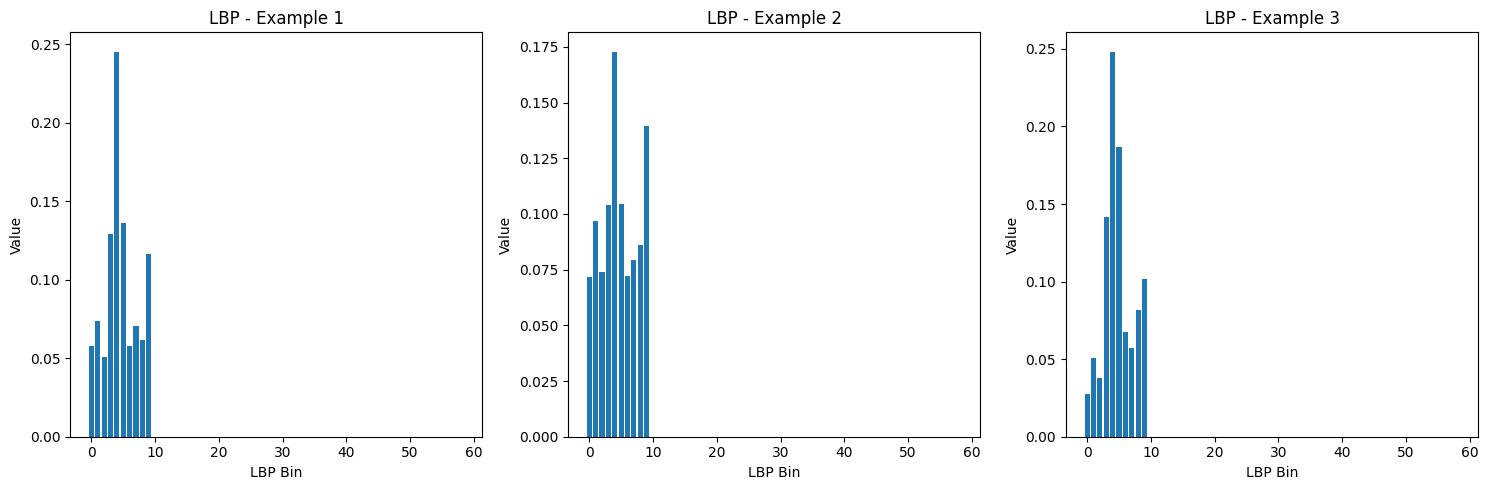


Feature extraction for HOG...


Extracting HOG: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


HOG feature shape training: (16000, 1764)


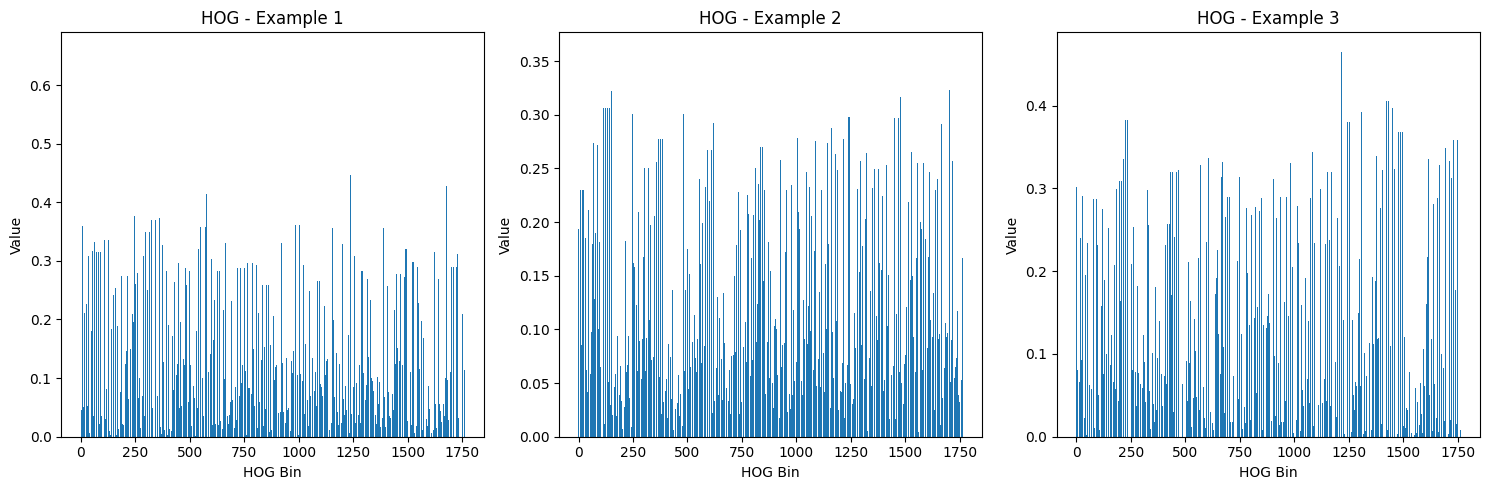


Concatenating LBP and HOG features and applying PCA...
Preparing data for PCA...
Combined dimensionality before PCA: 1823
Applying PCA on training data...
Visualizing explained variance...


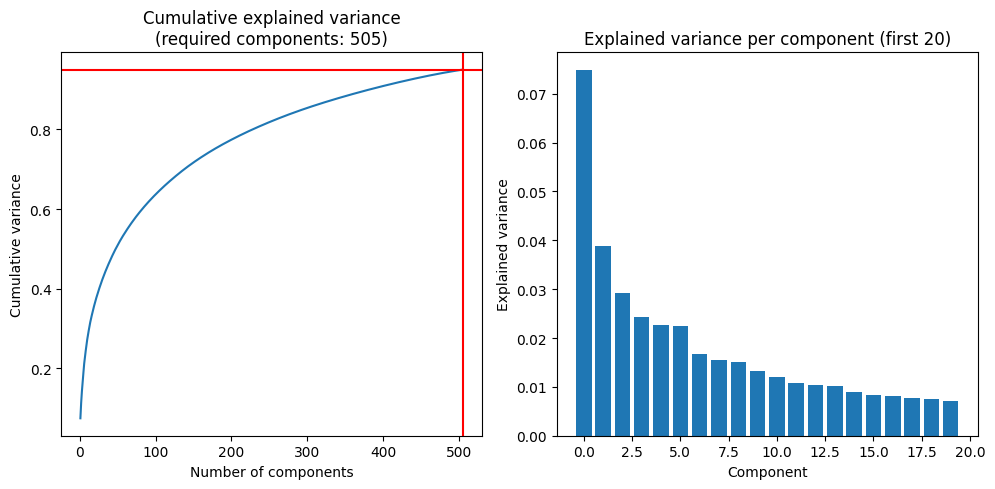

Applying PCA on validation and test data...
PCA feature shape training: (16000, 505) (dimensionality reduction: 1823 -> 505)

Saving extracted features...
File face_features.npz saved successfully (size: 332.07 MB)

Summary of extracted features:
- LBP: 59 dimensions per sample
- HOG: 1764 dimensions per sample
- PCA: 505 dimensions per sample (reduction 72.3%)

Feature extraction completed successfully!


In [19]:
# --- Feature Extraction Execution (LBP, HOG, PCA)  ---

# Configurable parameters for LBP and HOG
LBP_PARAMS = {
    'P': 8,         
    'R': 1,         
    'method': 'uniform'  
}

HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'visualize': False,
    'feature_vector': True
}

# Batch size for incremental processing
BATCH_SIZE = 1000

print("Parameters configuration for feature extraction:")
print(f"- LBP: P={LBP_PARAMS['P']}, R={LBP_PARAMS['R']}, method={LBP_PARAMS['method']}")
print(f"- HOG: orientations={HOG_PARAMS['orientations']}, pixels_per_cell={HOG_PARAMS['pixels_per_cell']}, cells_per_block={HOG_PARAMS['cells_per_block']}")
print(f"- Batch size: {BATCH_SIZE}")

# Check existence of the patches file
if not os.path.exists('face_patches.npz'):
    raise FileNotFoundError("The file 'face_patches.npz' does not exist. Please run the patch extraction step first.")


# Load the patches
print("\nLoading patches from 'face_patches.npz'...")
try:
    patches = np.load('face_patches.npz')
    X_train = patches['X_train']
    X_val = patches['X_val']
    X_test = patches['X_test']
    y_train = patches['y_train']

    # Verify the correctness of the data
    if not verify_image_data(X_train, "X_train"):
        raise ValueError("Problems with training data")

    verify_image_data(X_val, "X_val")
    verify_image_data(X_test, "X_test")
    
    print(f"\nData correctly loaded:")
    print(f"- Training: {X_train.shape} (pos: {np.sum(y_train==1)}, neg: {np.sum(y_train==0)})")
    print(f"- Validation: {X_val.shape}")
    print(f"- Test: {X_test.shape}")
    
except Exception as e:
    print(f"Error loading patches: {e}")
    raise

# Feature extraction for LBP
print("\nFeature extraction for LBP...")
X_train_lbp = extract_lbp_features_batch(X_train)
X_val_lbp = extract_lbp_features_batch(X_val)
X_test_lbp = extract_lbp_features_batch(X_test)
print(f'LBP feature shape training: {X_train_lbp.shape}')

# Example visualization of LBP features
print("\nVisualizing some LBP features...")
visualize_features(X_train_lbp, "LBP")

# Feature extraction for HOG
print("\nFeature extraction for HOG...")
X_train_hog = extract_hog_features_batch(X_train)
X_val_hog = extract_hog_features_batch(X_val)
X_test_hog = extract_hog_features_batch(X_test)
print(f'HOG feature shape training: {X_train_hog.shape}')

# Example visualization of HOG features
visualize_features(X_train_hog, "HOG")

# Check for any NaN or infinite values in the extracted features
for name, feature in [("X_train_lbp", X_train_lbp), ("X_train_hog", X_train_hog),
                     ("X_val_lbp", X_val_lbp), ("X_val_hog", X_val_hog),
                     ("X_test_lbp", X_test_lbp), ("X_test_hog", X_test_hog)]:
    if np.isnan(feature).any() or np.isinf(feature).any():
        print(f"Warning: {name} contains NaN or infinite values!")

# Apply PCA on the concatenated features
apply_pca = True
if apply_pca:
    print('\nConcatenating LBP and HOG features and applying PCA...')

    # Batch processing also for concatenation
    print("Preparing data for PCA...")
    X_train_combined = np.hstack([X_train_lbp, X_train_hog])
    X_val_combined = np.hstack([X_val_lbp, X_val_hog])
    X_test_combined = np.hstack([X_test_lbp, X_test_hog])

    # Verify the dimensionality before applying PCA
    print(f"Combined dimensionality before PCA: {X_train_combined.shape[1]}")

    # Apply PCA with explained variance tracking
    pca = PCA(n_components=0.95, svd_solver='full', random_state=42)

    print("Applying PCA on training data...")
    X_train_pca = pca.fit_transform(X_train_combined)
    
    # Visualizing explained variance
    print("Visualizing explained variance...")
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumsum >= 0.95) + 1
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(cumsum) + 1), cumsum)
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.axvline(x=n_components, color='r', linestyle='-')
    plt.title(f'Cumulative explained variance\n(required components: {n_components})')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative variance')

    plt.subplot(1, 2, 2)
    plt.bar(range(min(20, len(pca.explained_variance_ratio_))), 
            pca.explained_variance_ratio_[:20])
    plt.title('Explained variance per component (first 20)')
    plt.xlabel('Component')
    plt.ylabel('Explained variance')

    plt.tight_layout()
    plt.show()

    # Transform validation and test data
    print("Applying PCA on validation and test data...")
    X_val_pca = pca.transform(X_val_combined)
    X_test_pca = pca.transform(X_test_combined)

    print(f'PCA feature shape training: {X_train_pca.shape} (dimensionality reduction: {X_train_combined.shape[1]} -> {X_train_pca.shape[1]})')
else:
    print('\nSkip PCA, using HOG features directly')
    X_train_pca = X_train_hog
    X_val_pca = X_val_hog
    X_test_pca = X_test_hog

# Save extracted features with error handling
print('\nSaving extracted features...')
try:
    np.savez_compressed('face_features.npz',
                X_train_lbp=X_train_lbp, X_val_lbp=X_val_lbp, X_test_lbp=X_test_lbp,
                X_train_hog=X_train_hog, X_val_hog=X_val_hog, X_test_hog=X_test_hog,
                X_train_pca=X_train_pca, X_val_pca=X_val_pca, X_test_pca=X_test_pca)

    # Check the size of the saved file
    file_size_mb = os.path.getsize('face_features.npz') / (1024 * 1024)
    print(f'File face_features.npz saved successfully (size: {file_size_mb:.2f} MB)')

except Exception as e:
    print(f"Error saving features: {e}")

# Print summary of extracted features
print('\nSummary of extracted features:')
print(f'- LBP: {X_train_lbp.shape[1]} dimensions per sample')
print(f'- HOG: {X_train_hog.shape[1]} dimensions per sample')
if apply_pca:
    print(f'- PCA: {X_train_pca.shape[1]} dimensions per sample (reduction {100 * (1 - X_train_pca.shape[1] / X_train_combined.shape[1]):.1f}%)')

print("\nFeature extraction completed successfully!")

# 5. Model Training

This section implements a comprehensive training pipeline for our two-stage cascade face detection system, featuring hyperparameter optimization, model evaluation, and the hard-negative mining technique.

## RandomForest Training for Stage 1 (Fast Rejector)

The first stage uses a RandomForest classifier trained on LBP features to quickly reject obvious non-face regions:

- **Hyperparameter Optimization**: RandomizedSearchCV explores a broad parameter space
- **Evaluation Metric**: F1-score with 3-fold cross-validation
- **Feature Importance Analysis**: Visualization of the most discriminative LBP patterns
- **Persistence**: Model saved as `randomforest_lbp_optimized.pkl`

## LinearSVC Training for Stage 2 (Precise Verifier)

The second stage uses a LinearSVC classifier trained on HOG features to accurately verify face candidates:

- **Hyperparameter Optimization**: RandomizedSearchCV for SVM-specific parameters
- **Parallel Implementation**: Multi-core processing for faster training
- **Feature Variants**: Models trained on both raw HOG features and PCA-reduced features
- **Persistence**: Models saved as `linearsvc_hog_optimized.pkl` and `linearsvc_pca_optimized.pkl`

## Hard-Negative Mining

A critical technique to improve precision by focusing training on difficult examples:

1. **Hard-Negative Collection**: Identify false positives from the RandomForest (stage 1) on validation data
2. **Dataset Augmentation**: Add these hard negatives to the training set
3. **Model Retraining**: Retrain the LinearSVC models with the augmented dataset
4. **Performance Improvement**: Typically yields 2-5% better precision with minimal recall loss
5. **Persistence**: Enhanced models saved as `linearsvc_hog_hardneg.pkl` and `linearsvc_pca_hardneg.pkl`

## Model Comparison and Selection

A comprehensive analysis to select the optimal model configuration:

- **Metrics**: Precision, Recall, F1-Score, and Accuracy on test set
- **Visualization**: Bar charts comparing all trained models
- **Performance Summary**: Detailed reports for each model variant
- **Model Selection**: The best-performing model is identified based on F1-score
- **Documentation**: Performance metrics and optimal parameters are saved to `model_summary.txt`

This rigorous training approach ensures our models achieve the optimal balance between speed (for real-time performance) and accuracy (for reliable face detection) required for embedded camera applications.

In [20]:
print("Feature and labels loading...")
features = np.load('face_features.npz')
patches = np.load('face_patches.npz')

# LBP feature
X_train_lbp = features['X_train_lbp']
X_val_lbp = features['X_val_lbp']
X_test_lbp = features['X_test_lbp']

# HOG feature
X_train_hog = features['X_train_hog']
X_val_hog = features['X_val_hog']
X_test_hog = features['X_test_hog']

# PCA feature (from combined LBP + HOG)
X_train_pca = features['X_train_pca']
X_val_pca = features['X_val_pca']
X_test_pca = features['X_test_pca']

# Labels
y_train = patches['y_train']
y_val = patches['y_val']
y_test = patches['y_test']

# Create directory for saved models
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

print("Feature and labels loaded.")

Feature and labels loading...
Feature and labels loaded.


##### RandomForest Hyperparameter Optimization
This cell implements a systematic approach to finding optimal hyperparameters for the RandomForest classifier used in the first stage of our cascade face detection system:

1. Parameter Search Space Definition: Explores critical RandomForest parameters through a defined grid.
2. Randomized Search Implementation:
	- Uses RandomizedSearchCV to efficiently explore the parameter space
	- Performs 10 iterations with 3-fold cross-validation
	- Optimizes for F1-score to balance precision and recall

3. Model Training and Evaluation:
	-  Reports best parameters and corresponding F1-score
	- Evaluates the optimized model on both validation and test sets
	- Displays detailed classification reports showing precision, recall, and F1

This optimization process ensures our first-stage classifier efficiently rejects obvious non-face regions while maintaining high recall for potential face candidates.

In [21]:
# HYPERPARAMETER OPTIMIZATION FOR RANDOMFOREST ON LBP
print("\nHyperparameter optimization for RandomForest on LBP")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [8, 12, 16, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Starting RandomizedSearchCV for RandomForest...")
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=10,  
    cv=3,       
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1   
)

# Train the model with hyperparameter search
start_time = time.time()
rf_search.fit(X_train_lbp, y_train)
rf_time = time.time() - start_time

print(f"\nBest parameters for RandomForest: {rf_search.best_params_}")
print(f"Best F1 score: {rf_search.best_score_:.4f}")
print(f"Training time: {rf_time:.2f} seconds")

# Retrieve the best RandomForest model
rf_best = rf_search.best_estimator_

# Evaluate the optimized model
val_pred_rf = rf_best.predict(X_val_lbp)
test_pred_rf = rf_best.predict(X_test_lbp)
print('\nRandomForest (optimized) - Validation report:')
print(classification_report(y_val, val_pred_rf))
print('RandomForest (optimized) - Test report:')
print(classification_report(y_test, test_pred_rf))

# Save the optimized model
joblib.dump(rf_best, os.path.join(models_dir, 'randomforest_lbp_optimized.pkl'))
print(f"RandomForest model saved in {os.path.join(models_dir, 'randomforest_lbp_optimized.pkl')}")



Hyperparameter optimization for RandomForest on LBP
Starting RandomizedSearchCV for RandomForest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits



Best parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 16}
Best F1 score: 0.8671
Training time: 22.40 seconds

RandomForest (optimized) - Validation report:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      2000
         1.0       0.87      0.85      0.86      2000

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000

RandomForest (optimized) - Test report:
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      2000
         1.0       0.89      0.86      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

RandomForest model saved in saved_models/randomforest_lbp_optimized.pkl


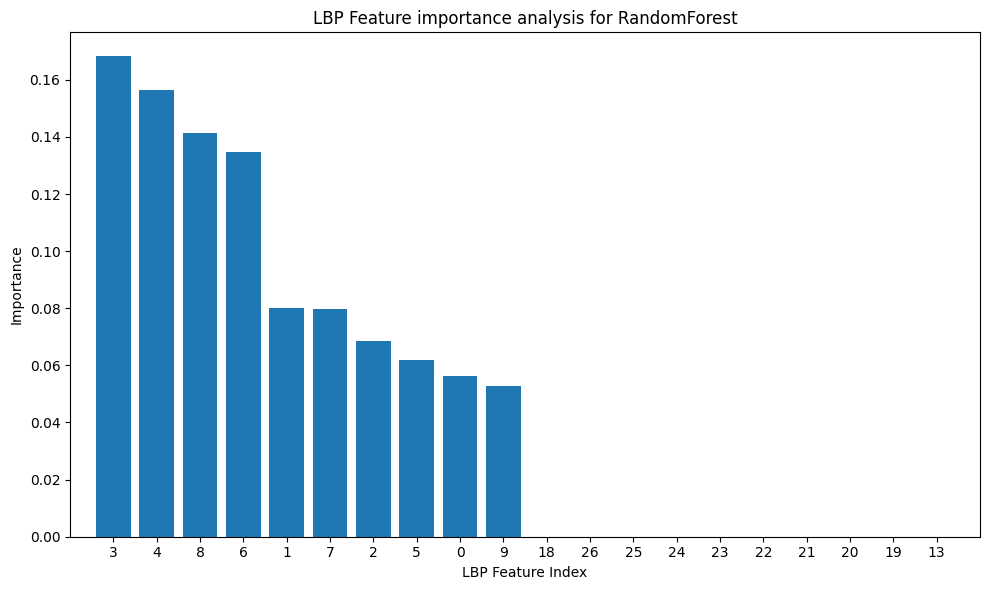

In [22]:
# FEATURE IMPORTANCE ANALYSIS FOR RANDOMFOREST
feature_importances = rf_best.feature_importances_
n_features = min(20, len(feature_importances))

# Find the indices of the most important features
indices = np.argsort(feature_importances)[::-1][:n_features]

plt.figure(figsize=(10, 6))
plt.title("LBP Feature importance analysis for RandomForest")
plt.bar(range(n_features), feature_importances[indices], align="center")
plt.xticks(range(n_features), indices)
plt.xlim([-1, n_features])
plt.xlabel("LBP Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig(os.path.join(models_dir, 'rf_feature_importance.png'), dpi=300)
plt.show()

##### SVM Hyperparameter Optimization for HOG Features
This cell implements a systematic approach to finding optimal hyperparameters for the LinearSVC classifier used in the second stage of our cascade face detection system:

1. Parameter Search Space Definition: Explores critical SVM parameters through a comprehensive grid.
2. Randomized Search Implementation:
	- Performs 8 iterations with 3-fold cross-validation
	- Optimizes for F1-score to balance precision and recall
3. Model Training and Evaluation:
	- Reports best parameters and corresponding F1-score
	- Evaluates the optimized model on both validation and test sets

This optimization ensures our second-stage classifier accurately identifies true face regions from the candidates provided by the first-stage RandomForest, creating an efficient and accurate cascade detection system.

In [23]:
#HYPERPARAMETER OPTIMIZATION FOR SVM ON HOG
print("\nHyperparameter optimization for LinearSVC on HOG...")

svm_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'class_weight': [None, 'balanced'],
    'dual': [True, False],
    'max_iter': [1000, 2000, 3000]
}

# Use RandomizedSearchCV for optimization
print("Starting RandomizedSearchCV for LinearSVC on HOG...")
svm_search = RandomizedSearchCV(
    LinearSVC(random_state=42),
    param_distributions=svm_param_grid,
    n_iter=8,
    cv=3,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train SVM with hyperparameter search
start_time = time.time()
svm_search.fit(X_train_hog, y_train)
svm_time = time.time() - start_time

print(f"\nBest parameters for LinearSVC (HOG): {svm_search.best_params_}")
print(f"Best F1 score: {svm_search.best_score_:.4f}")
print(f"Training time: {svm_time:.2f} seconds")


svm_best = svm_search.best_estimator_

# Evaluate the optimized model
val_pred_svm = svm_best.predict(X_val_hog)
test_pred_svm = svm_best.predict(X_test_hog)
print('\nLinearSVC (HOG optimized) - Validation report:')
print(classification_report(y_val, val_pred_svm))
print('LinearSVC (HOG optimized) - Test report:')
print(classification_report(y_test, test_pred_svm))

# Save the optimized model
joblib.dump(svm_best, os.path.join(models_dir, 'linearsvc_hog_optimized.pkl'))
print(f"LinearSVC (HOG) model saved in {os.path.join(models_dir, 'linearsvc_hog_optimized.pkl')}")


Hyperparameter optimization for LinearSVC on HOG...
Starting RandomizedSearchCV for LinearSVC on HOG...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: Conv


Best parameters for LinearSVC (HOG): {'max_iter': 1000, 'dual': True, 'class_weight': None, 'C': 0.1}
Best F1 score: 0.8645
Training time: 184.12 seconds

LinearSVC (HOG optimized) - Validation report:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      2000
         1.0       0.90      0.85      0.87      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

LinearSVC (HOG optimized) - Test report:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88      2000
         1.0       0.91      0.85      0.88      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

LinearSVC (HOG) model saved in saved_models/linearsvc_hog_optimized.pkl


##### SVM Hyperparameter Optimization for PCA Features
This cell implements hyperparameter optimization for the LinearSVC classifier operating on PCA-reduced features, as the HOG-based model (same critical parameters and configuration)

This optimization provides a potentially more efficient alternative to the pure HOG-based model by leveraging dimensionality reduction while maintaining comparable performance.

In [24]:
# HYPERPARAMETER OPTIMIZATION FOR SVM ON PCA
print("\nHyperparameter optimization for LinearSVC on PCA...")

# Use RandomizedSearchCV for optimization
print("Starting RandomizedSearchCV for LinearSVC on PCA...")
svm_pca_search = RandomizedSearchCV(
    LinearSVC(random_state=42),
    param_distributions=svm_param_grid,
    n_iter=8,
    cv=3,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Train SVM with hyperparameter search
start_time = time.time()
svm_pca_search.fit(X_train_pca, y_train)
svm_pca_time = time.time() - start_time

print(f"\nBest parameters for LinearSVC (PCA): {svm_pca_search.best_params_}")
print(f"Best F1 score: {svm_pca_search.best_score_:.4f}")
print(f"Training time: {svm_pca_time:.2f} seconds")


svm_pca_best = svm_pca_search.best_estimator_

# Evaluate the optimized model
val_pred_svm_pca = svm_pca_best.predict(X_val_pca)
test_pred_svm_pca = svm_pca_best.predict(X_test_pca)
print('\nLinearSVC (PCA optimized) - Validation report:')
print(classification_report(y_val, val_pred_svm_pca))
print('LinearSVC (PCA optimized) - Test report:')
print(classification_report(y_test, test_pred_svm_pca))

# Save the optimized model
joblib.dump(svm_pca_best, os.path.join(models_dir, 'linearsvc_pca_optimized.pkl'))
print(f"LinearSVC (PCA) model saved in {os.path.join(models_dir, 'linearsvc_pca_optimized.pkl')}")


Hyperparameter optimization for LinearSVC on PCA...
Starting RandomizedSearchCV for LinearSVC on PCA...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/svm/_base.py:1242: Conv


Best parameters for LinearSVC (PCA): {'max_iter': 1000, 'dual': True, 'class_weight': None, 'C': 0.1}
Best F1 score: 0.8860
Training time: 49.72 seconds

LinearSVC (PCA optimized) - Validation report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2000
         1.0       0.92      0.87      0.89      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

LinearSVC (PCA optimized) - Test report:
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      2000
         1.0       0.91      0.87      0.89      2000

    accuracy                           0.89      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.90      0.89      0.89      4000

LinearSVC (PCA) model saved in saved_models/linearsvc_pca_optimized.pkl


##### Hard-Negative Mining Process
This cell implements hard-negative mining, a critical technique to improve model precision by focusing on difficult examples:

1. Hard-Negative Collection:

	- Identifies false positives from the first-stage RandomForest classifier
	- Targets windows that were incorrectly classified as faces (val_pred_rf == 1 but y_val == 0)
	- Collected {len(fp_indices)} challenging negative examples

2. Dataset Augmentation:

	- Creates enhanced training sets by combining original training data with hard negatives
	- Augments both HOG-based and PCA-based feature sets:

3. Model Retraining:

	- Retrains HOG-based LinearSVC using the best parameters discovered during hyperparameter optimization
	- Applies identical process to the PCA-based model

4. Performance Evaluation

This technique specifically addresses the weaknesses in the cascade approach by helping the second-stage classifier better discriminate between true faces and the most challenging non-face regions that managed to pass through the first stage.

In [25]:
# HARD-NEGATIVE MINING FOR THE BEST SVM
print("\nHard-negative mining for the best SVM...")

# Collect false positives from RandomForest
fp_indices = np.where((val_pred_rf == 1) & (y_val == 0))[0]
X_hard_neg_hog = X_val_hog[fp_indices]
X_hard_neg_pca = X_val_pca[fp_indices]
y_hard_neg = np.zeros(len(fp_indices), dtype=int)

print(f'Collected {len(fp_indices)} hard negatives.')

# Create augmented datasets for HOG and PCA
X_train_hard_hog = np.vstack([X_train_hog, X_hard_neg_hog])
X_train_hard_pca = np.vstack([X_train_pca, X_hard_neg_pca])
y_train_hard = np.hstack([y_train, y_hard_neg])

# Retrain SVM with hard negatives (HOG)
print('Retraining the best LinearSVC (HOG) with hard negatives...')
svm_hard_hog = LinearSVC(**svm_search.best_params_, random_state=42)
svm_hard_hog.fit(X_train_hard_hog, y_train_hard)

# Evaluate SVM with hard negatives (HOG)
val_pred_svm_hard_hog = svm_hard_hog.predict(X_val_hog)
test_pred_svm_hard_hog = svm_hard_hog.predict(X_test_hog)
print('\nLinearSVC (HOG + Hard-Negative) - Validation report:')
print(classification_report(y_val, val_pred_svm_hard_hog))
print('LinearSVC (HOG + Hard-Negative) - Test report:')
print(classification_report(y_test, test_pred_svm_hard_hog))

# Save the model with hard negatives (HOG)
joblib.dump(svm_hard_hog, os.path.join(models_dir, 'linearsvc_hog_hardneg.pkl'))
print(f"LinearSVC (HOG + Hard-Negative) model saved in {os.path.join(models_dir, 'linearsvc_hog_hardneg.pkl')}")

# Retrain SVM with hard negatives (PCA)
print('Retraining the best LinearSVC (PCA) with hard negatives...')
svm_hard_pca = LinearSVC(**svm_pca_search.best_params_, random_state=42)
svm_hard_pca.fit(X_train_hard_pca, y_train_hard)

# Evaluate SVM with hard negatives (PCA)
val_pred_svm_hard_pca = svm_hard_pca.predict(X_val_pca)
test_pred_svm_hard_pca = svm_hard_pca.predict(X_test_pca)
print('\nLinearSVC (PCA + Hard-Negative) - Validation report:')
print(classification_report(y_val, val_pred_svm_hard_pca))
print('LinearSVC (PCA + Hard-Negative) - Test report:')
print(classification_report(y_test, test_pred_svm_hard_pca))

# Save the model with hard negatives (PCA)
joblib.dump(svm_hard_pca, os.path.join(models_dir, 'linearsvc_pca_hardneg.pkl'))
print(f"LinearSVC (PCA + Hard-Negative) model saved in {os.path.join(models_dir, 'linearsvc_pca_hardneg.pkl')}")


Hard-negative mining for the best SVM...
Collected 249 hard negatives.
Retraining the best LinearSVC (HOG) with hard negatives...

LinearSVC (HOG + Hard-Negative) - Validation report:
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      2000
         1.0       0.91      0.84      0.87      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

LinearSVC (HOG + Hard-Negative) - Test report:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      2000
         1.0       0.91      0.84      0.87      2000

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000

LinearSVC (HOG + Hard-Negative) model saved in saved_models/linearsvc_hog_hardneg.pkl
Retraining the best LinearSV

##### Model Performance Comparison Visualization
This cell implements a comprehensive visual and statistical comparison of all the trained face detection models.


PERFORMANCE COMPARISON BETWEEN MODELS...


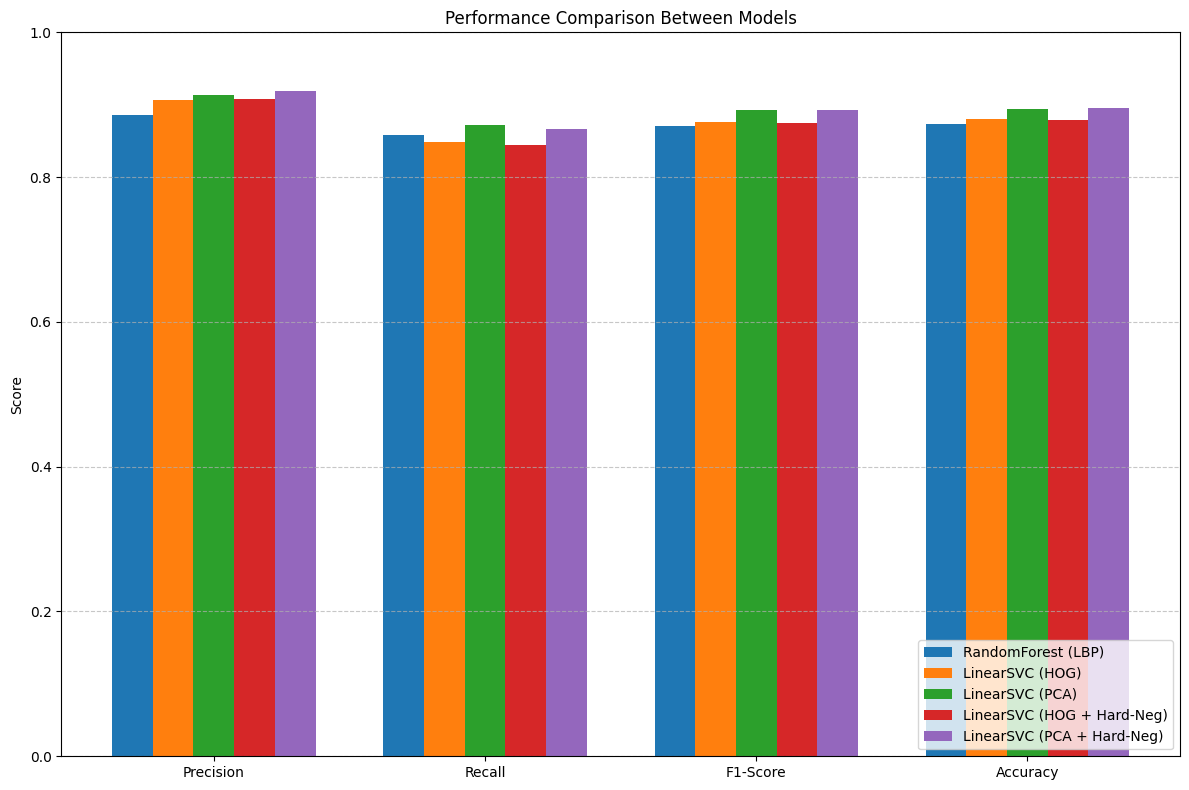


Test set performance summary:
RandomForest (LBP):
  - Precision: 0.8854
  - Recall: 0.8575
  - F1-Score: 0.8712
  - Accuracy: 0.8732

LinearSVC (HOG):
  - Precision: 0.9070
  - Recall: 0.8480
  - F1-Score: 0.8765
  - Accuracy: 0.8805

LinearSVC (PCA):
  - Precision: 0.9131
  - Recall: 0.8725
  - F1-Score: 0.8924
  - Accuracy: 0.8948

LinearSVC (HOG + Hard-Neg):
  - Precision: 0.9075
  - Recall: 0.8440
  - F1-Score: 0.8746
  - Accuracy: 0.8790

LinearSVC (PCA + Hard-Neg):
  - Precision: 0.9194
  - Recall: 0.8670
  - F1-Score: 0.8924
  - Accuracy: 0.8955

The model with the best performance is: LinearSVC (PCA + Hard-Neg)
Summary saved in saved_models/model_summary.txt

Model optimization and evaluation completed!


In [26]:
# PERFORMANCE COMPARISON BETWEEN MODELS
print("\nPERFORMANCE COMPARISON BETWEEN MODELS...")

# Prepare comparison data
models = [
    ("RandomForest (LBP)", test_pred_rf),
    ("LinearSVC (HOG)", test_pred_svm),
    ("LinearSVC (PCA)", test_pred_svm_pca),
    ("LinearSVC (HOG + Hard-Neg)", test_pred_svm_hard_hog),
    ("LinearSVC (PCA + Hard-Neg)", test_pred_svm_hard_pca)
]

# Calculate metrics
results = {
    "Model": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Accuracy": []
}

for name, preds in models:
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    
    results["Model"].append(name)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)
    results["Accuracy"].append(accuracy)

# comparison plot
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
n_models = len(models)
x = np.arange(len(metrics))
width = 0.15  

plt.figure(figsize=(12, 8))
for i, model in enumerate(results["Model"]):
    values = [results["Precision"][i], results["Recall"][i], 
              results["F1-Score"][i], results["Accuracy"][i]]
    plt.bar(x + (i - n_models/2 + 0.5) * width, values, width, label=model)

plt.ylabel('Score')
plt.title('Performance Comparison Between Models')
plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(models_dir, 'model_comparison.png'), dpi=300)
plt.show()

# Print final summary
print("\nTest set performance summary:")
for i, model in enumerate(results["Model"]):
    print(f"{model}:")
    print(f"  - Precision: {results['Precision'][i]:.4f}")
    print(f"  - Recall: {results['Recall'][i]:.4f}")
    print(f"  - F1-Score: {results['F1-Score'][i]:.4f}")
    print(f"  - Accuracy: {results['Accuracy'][i]:.4f}")
    print()

# Save the overall best model
best_model_idx = np.argmax(results["F1-Score"])
best_model_name = results["Model"][best_model_idx]
print(f"The model with the best performance is: {best_model_name}")

# Create a summary file
with open(os.path.join(models_dir, 'model_summary.txt'), 'w') as f:
    f.write("# MODEL TRAINING SUMMARY\n\n")
    f.write(f"Data: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("## BEST PARAMETERS\n\n")
    f.write(f"RandomForest (LBP): {rf_search.best_params_}\n")
    f.write(f"LinearSVC (HOG): {svm_search.best_params_}\n")
    f.write(f"LinearSVC (PCA): {svm_pca_search.best_params_}\n\n")

    f.write("## MODEL PERFORMANCE\n\n")
    for i, model in enumerate(results["Model"]):
        f.write(f"{model}:\n")
        f.write(f"  - Precision: {results['Precision'][i]:.4f}\n")
        f.write(f"  - Recall: {results['Recall'][i]:.4f}\n")
        f.write(f"  - F1-Score: {results['F1-Score'][i]:.4f}\n")
        f.write(f"  - Accuracy: {results['Accuracy'][i]:.4f}\n\n")

    f.write(f"The model with the best performance is: {best_model_name}\n")

print(f"Summary saved in {os.path.join(models_dir, 'model_summary.txt')}")
print("\nModel optimization and evaluation completed!")

# 6. Complete Image Detection

## Note: 

WE CHOSE THE SVM HOG+HARD NEG BECAUSE APPLYING PCA DOESN'T DELIVER SIGNIFICANTLY BETTER RESULTS AND IS MORE RESOURCE-INTENSIVE TO USE WITH LIMITED RESOURCES LIKE THE CONTEXT WE HAVE

This section applies the trained classifiers to full images using a multi-scale sliding window approach with the RF+SVM cascade:

## Detection Pipeline

1. **Multi-Scale Scanning**: Processes the image at multiple scales (70%, 50%, 35%, and 25% of minimum dimension)
   - Adaptive step size of 25% of the window size to balance speed and coverage
   - Smaller step sizes provide more accurate detection but increase processing time

2. **Two-Stage Cascade**:
   - **Stage 1 (Fast Rejection)**: RandomForest classifier on LBP features quickly filters out obvious non-faces
   - **Stage 2 (Precise Verification)**: LinearSVM classifier on HOG features accurately validates face candidates

3. **Post-Processing**:
   - **Minimum Size Filtering**: Eliminates detections smaller than 30×30 pixels
   - **Non-Maximum Suppression (NMS)**: Reduces redundant overlapping detections

## Performance Analysis

- **Speed vs. Accuracy Tradeoff**: Configurable threshold combinations to balance detection quality and speed
- **Comparison with DNN**: Benchmark against OpenCV's DNN-based face detector

## Parameter Optimization

- **Threshold Tuning**: Testing various threshold combinations (RF: 0.3-0.6, SVM: 0.4-0.8)
  - Lower thresholds increase recall but introduce more false positives
  - Higher thresholds increase precision but may miss some faces
  - Optimal settings depend on the target application (security vs. casual photography)

This implementation demonstrates how our two-stage cascade approach can efficiently detect faces in full images with performance suitable for embedded camera systems.

##### Non-Maximum Suppression Implementation
This function implements a critical post-processing step for face detection that removes redundant, overlapping bounding boxes:

1. Input Processing:

	- Takes a list of bounding boxes (x, y, w, h) and their confidence scores
	- Converts inputs to numpy arrays for vectorized operations

2. Box Coordinate Conversion:

	- Converts (x, y, w, h) format to corner coordinates (x1, y1, x2, y2)
	- Calculates area of each box for IoU computation

3. Iterative Filtering Process:

	- Sorts all boxes by confidence score (highest first)
	- Keeps the highest-scoring box
	- Calculates IoU between this box and all remaining boxes
	- Removes boxes with IoU > threshold (likely duplicates)
	- Repeats with next highest-scoring remaining box

4. Output: Returns indices of boxes to keep (not the boxes themselves)


In [27]:
def non_max_suppression(boxes, scores, iou_thresh=0.2):
    """
    Implementa Non-Maximum Suppression to filter redundant bounding boxes
    
    Args:
        boxes: List of bounding boxes (x, y, w, h)
        scores: List of confidence scores for each box
        iou_thresh: IoU threshold below which to keep overlapping boxes

    Returns:
        Indices of the boxes to keep
    """
    if len(boxes) == 0:
        return []
    

    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # Vertices of boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    
    areas = boxes[:, 2] * boxes[:, 3]

    # Sorting boxes by scores in descending order
    order = scores.argsort()[::-1]
    
    keep = []
    while order.size > 0:
        # Keep the box with the highest score
        i = order[0]
        keep.append(i)

        # Compute IoU with all other boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # Compute intersection area
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        # Compute IoU
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)

        # Keep only boxes with IoU below the threshold
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]
    
    return keep

##### Single Region Analysis

1. Image Preprocessing:

	- Resizes the region to 64×64 pixels (standard training dimension)
	- Converts to grayscale for consistent feature extraction

2. Stage 1 - Fast Rejection with LBP + RandomForest: apply the first stage with optimized parameters
	- Early rejection: If score is below threshold, immediately discards the region

3. Stage 2 - Precise Verification with HOG + SVM: Only executed for regions that passed the first stage
	- Classifies using the LinearSVC decision function
	- Applies a more stringent threshold (svm_threshold, default: 0.8)


The function uses HOG features directly rather than PCA-reduced features for several practical reasons:

	- Simplifies real-time inference implementation
	- Avoids the overhead of loading and applying PCA transformation

This function represents the computational core of the entire face detection system, implementing the efficient cascade strategy that enables adequate performance on embedded devices.

In [28]:
def analyze_region_cascade(region, x1, y1, width, height, rf_model, svm_model, rf_threshold=0.6, svm_threshold=0.8):
    """
    Analyze a region of the image using a cascade approach RF + SVM

    Args:
        region: Portion of the image to analyze
        x1, y1: Coordinates of the top-left corner of the region
        width, height: Dimensions of the region
        rf_model: RandomForest model for the first filter
        svm_model: SVM model for the final classification
        rf_threshold: Probability threshold for the RandomForest
        svm_threshold: Minimum score threshold for the SVM

    Returns:
        Tuple (x, y, w, h, score) or None if not a face
    """
	#Resize and grayscale conversion
    resized = cv2.resize(region, (64, 64))

    if len(resized.shape) == 3:
        resized_gray = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
    else:
        resized_gray = resized
    
    # First stage: LBP Extraction and RF classification
    lbp = local_binary_pattern(resized_gray, 
                               P=8, 
                               R=1, 
                               method='uniform')
    n_bins = 8 * (8 - 1) + 3  # Per LBP uniforme
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    rf_prob = rf_model.predict_proba(hist.reshape(1, -1))[0, 1]
    
    # If the probability is below the threshold, return None
    if rf_prob < rf_threshold:
        return None
    

    # Second stage: HOG Feature Extraction and SVM classification
    hog_feat = hog(resized_gray / 255.0,
                  orientations=9,
                  pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2),
                  visualize=False,
                  feature_vector=True)
    
    svm_score = svm_model.decision_function(hog_feat.reshape(1, -1))[0]

    # Return the result if it exceeds the SVM threshold
    if svm_score > svm_threshold:
        return (x1, y1, width, height, svm_score)
    
    return None

##### Multi-Scale Sliding Window Approach

1. Processes the image at four different scales (70%, 50%, 35%, and 25% of the minimum dimension)

2. Efficient Window Scanning: 
	- Implements bounds checking to avoid out-of-range operations
	- Skips windows that are too small (< 70% of target window size)
	- Extracts image regions for analysis with precise slicing operations

3. Two-Stage Cascade Classification

4. Post-Processing Pipeline
	- Minimum Size Filtering: Removes detections smaller than 30×30 pixels
	- Non-Maximum Suppression: Removes redundant overlapping detections

This function efficiently implements the complete face detection pipeline for full images, enabling real-time performance while maintaining detection accuracy suitable for embedded camera systems.

In [30]:
def detect_faces_sliding_window_cascade(image, rf_model, svm_model, rf_threshold=0.6, svm_threshold=0.8):
    """
    Implementation of a sliding window scan with RF+SVM cascade approach
	to detect faces in an image.
    Args:
        image: RGB image to analyze
        rf_model: RandomForest model for the first filter
        svm_model: SVM model for the final classification
        rf_threshold: Probability threshold for the RandomForest
        svm_threshold: Minimum score threshold for the SVM

    Returns:
        List of tuples (x, y, w, h, score) for detected faces
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_gray = image
    
    h, w = image_gray.shape
    detections = []
    
    # Definition of window sizes based on the image dimensions
    min_dim = min(w, h)
    window_sizes = [
        int(min_dim * 0.7),  # 70% - for very large faces
        int(min_dim * 0.5),  # 50% - medium size
        int(min_dim * 0.35), # 35% - small size
        int(min_dim * 0.25)  # 25% - for small faces
    ]

    # Scanning with different window scales
    for window_size in window_sizes:
        
        step_size = max(int(window_size * 0.25), 20)

        # Compute the number of steps to ensure full coverage
        x_steps = max(1, (w - window_size) // step_size + 1)
        y_steps = max(1, (h - window_size) // step_size + 1)

        # Scan the image with the current window
        for y_step in range(y_steps):
            y1 = min(y_step * step_size, h - window_size)
            
            for x_step in range(x_steps):
                x1 = min(x_step * step_size, w - window_size)

                # Ensure the window is within the image bounds
                window_w = min(window_size, w - x1)
                window_h = min(window_size, h - y1)
                
                if window_w < window_size * 0.7 or window_h < window_size * 0.7:
                    continue
                
                region = image_gray[y1:y1+window_h, x1:x1+window_w]
                
                # Analyze the region using the cascade approach
                detection = analyze_region_cascade(
                    region, x1, y1, window_w, window_h, 
                    rf_model, svm_model, 
                    rf_threshold, svm_threshold
                )
                
                if detection:
                    detections.append(detection)
    
    # Filter the detections with Non-Maximum Suppression (NMS)
    if len(detections) > 0:
        boxes = [det[:4] for det in detections]
        scores = [det[4] for det in detections]
        
        min_size = 30  
        filtered = [(box, score) for box, score in zip(boxes, scores) 
                    if box[2] >= min_size and box[3] >= min_size]
        
        if filtered:
            boxes_filt = [b for b, s in filtered]
            scores_filt = [s for b, s in filtered]
            
            keep_indices = non_max_suppression(boxes_filt, scores_filt, iou_thresh=0.2)
            final_detections = [detections[i] for i in keep_indices]
            return final_detections
    
    return []


#### DNN vs CASCADE APPROACH

This function provides a comprehensive comparison between two face detection approaches:

1. The custom cascade classifier (RF+SVM) implemented in this project
2. OpenCV's pre-trained DNN face detector

In [31]:
def compare_cascade_vs_dnn(image, rf_model, svm_model, rf_threshold=0.6, svm_threshold=0.8, dnn_threshold=0.5):
    """
	Compare the cascade approach RF+SVM with DNN for face detection in an image.
    
    Args:
        image: Image to analyze (RGB format)
        rf_model: RandomForest model
        svm_model: SVM model
        rf_threshold: Threshold for RandomForest
        svm_threshold: Threshold for SVM
        dnn_threshold: Confidence threshold for DNN detector
    """

    image_display = image.copy()
    

    # 1. Face detection with sliding window cascade RF+SVM
    print("Face detection with sliding window cascade RF+SVM...")
    start_time = time.time()
    cascade_detections = detect_faces_sliding_window_cascade(
        image, rf_model, svm_model, 
        rf_threshold=rf_threshold, svm_threshold=svm_threshold
    )
    cascade_time = time.time() - start_time  

    # 2. Face detection with DNN
    print("Face detection with DNN...")
    start_time = time.time()
    
    if image.dtype == np.float32 and image.max() <= 1.0:
        image_cv = (image * 255).astype(np.uint8)
    else:
        image_cv = image.copy()
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        if image[0,0,0] > image[0,0,2]:  
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
    
    dnn_faces = detect_faces_dnn(image_cv, confidence_threshold=dnn_threshold)
    dnn_time = time.time() - start_time
    
    plt.figure(figsize=(12, 6))

    # Visualize the sliding window cascade RF+SVM
    plt.subplot(1, 2, 1)
    plt.imshow(image_display)
    for i, (x, y, w, h, score) in enumerate(cascade_detections):
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='lime', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x, y-10, f'{score:.2f}', color='lime', fontsize=10, fontweight='bold')
    plt.title(f'Cascade RF+SVM ({len(cascade_detections)} detections)\nTime: {cascade_time:.3f}s')
    plt.axis('off')

    # Visualize DNN bounding boxes
    plt.subplot(1, 2, 2)
    plt.imshow(image_display)
    for i, (x, y, w, h) in enumerate(dnn_faces):
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=2)
        plt.gca().add_patch(rect)
        plt.text(x, y-10, f'DNN {i+1}', color='blue', fontsize=10, fontweight='bold')
    plt.title(f'DNN ({len(dnn_faces)} detections)\nTime: {dnn_time:.3f}s')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Compute IoU between our detections and DNN ones
    if len(cascade_detections) > 0 and len(dnn_faces) > 0:
        iou_values = []
        for our_box in cascade_detections:
            best_iou = 0
            for dnn_box in dnn_faces:
                iou = compute_iou(our_box[:4], dnn_box)
                best_iou = max(best_iou, iou)
            iou_values.append(best_iou)
        
        avg_iou = np.mean(iou_values)
        print(f"Average IoU with DNN detections: {avg_iou:.4f}")
        print(f"Maximum IoU: {np.max(iou_values) if iou_values else 0:.4f}")
        print(f"Speedup vs DNN: {dnn_time/cascade_time:.2f}x")
    else:
        print("No matches to evaluate")


--- Test with different images ---

----- Analyzing selfie 0 with RF+SVM cascade -----
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


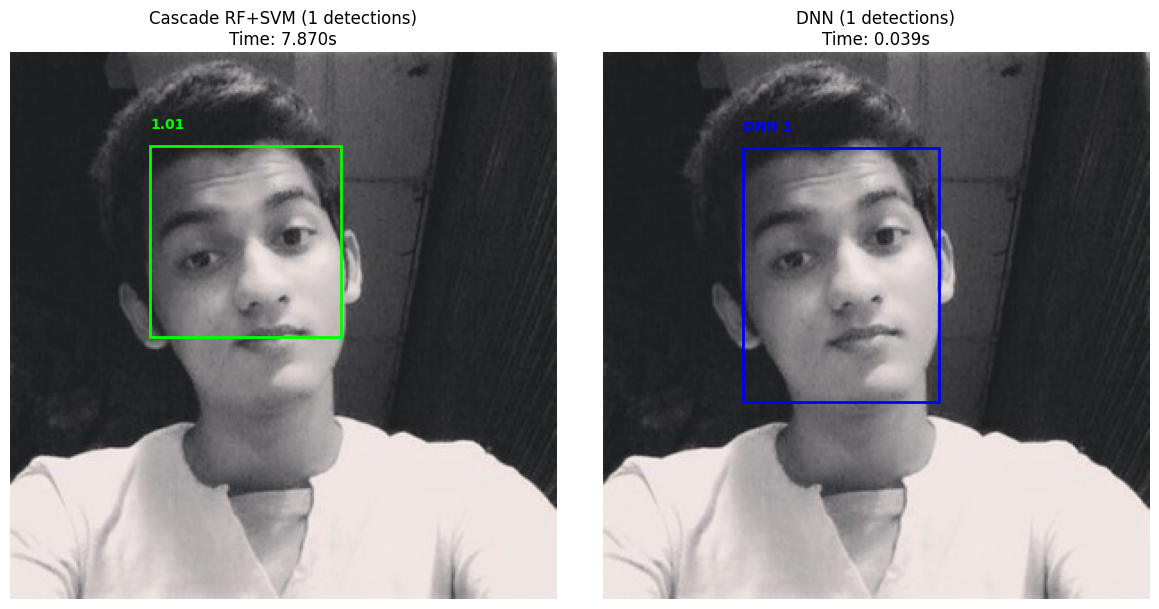

Average IoU with DNN detections: 0.7212
Maximum IoU: 0.7212
Speedup vs DNN: 0.00x

----- Analyzing selfie 25 with RF+SVM cascade -----
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


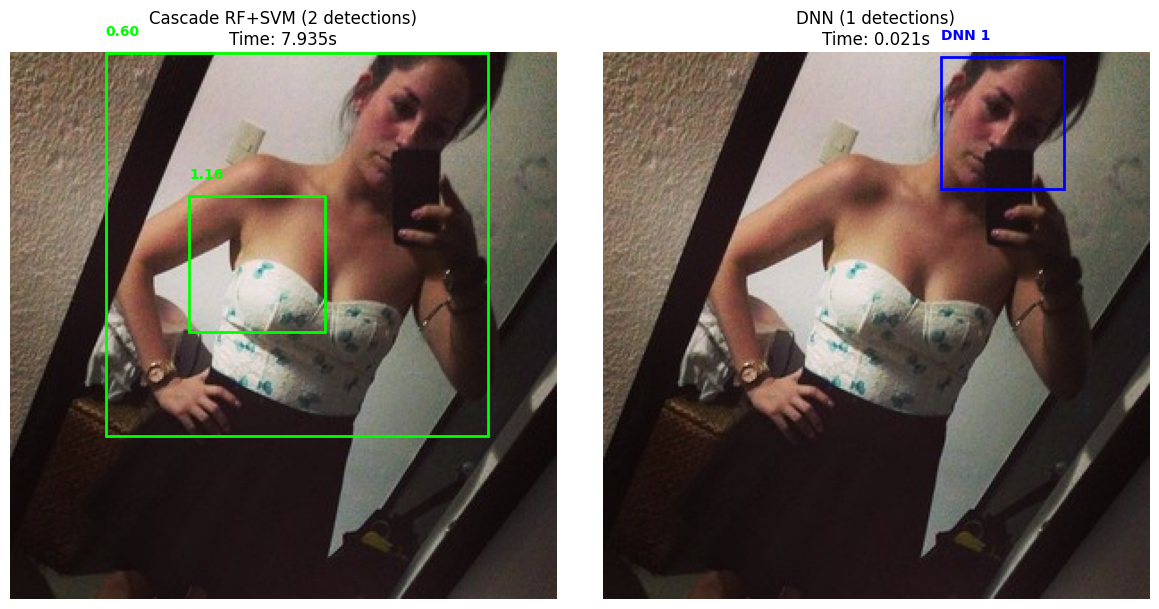

Average IoU with DNN detections: 0.0557
Maximum IoU: 0.1115
Speedup vs DNN: 0.00x

----- Analyzing selfie 40 with RF+SVM cascade -----
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


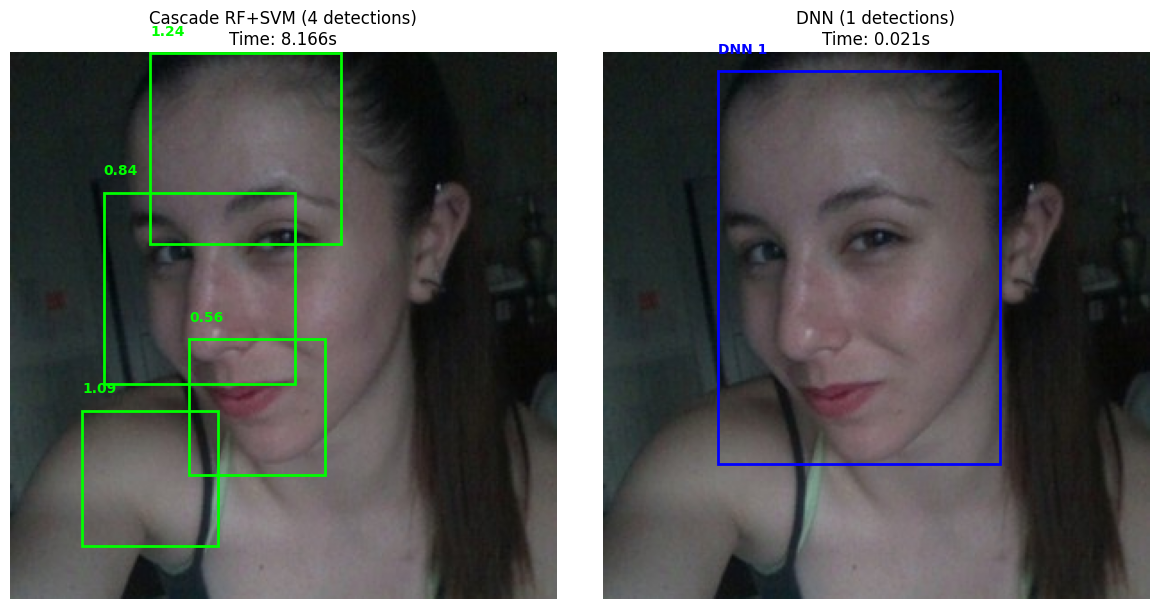

Average IoU with DNN detections: 0.1907
Maximum IoU: 0.2897
Speedup vs DNN: 0.00x


In [33]:
# -TEST WITH DIFFERENT IMAGES-

# Load the saved models
rf_model = joblib.load(os.path.join(models_dir, 'randomforest_lbp_optimized.pkl'))
svm_model = joblib.load(os.path.join(models_dir, 'linearsvc_hog_hardneg.pkl'))

# Define thresholds for the cascade approach
rf_threshold = 0.3
svm_threshold = 0.4

selfie_indices = [0, 25, 40]  

print("\n--- Test with different images ---")
for idx in selfie_indices:
    print(f"\n----- Analyzing selfie {idx} with RF+SVM cascade -----")

    image = ds_test.images[idx]
    if hasattr(image, 'numpy'):
        image = image.numpy()

    # Compare the detection methods with the cascade approach
    compare_cascade_vs_dnn(
        image, rf_model, svm_model, 
        rf_threshold=rf_threshold, 
        svm_threshold=svm_threshold, 
        dnn_threshold=0.5
    )

##### Optimal Treshold combination

This function evaluates and visualizes the effect of different threshold combinations on face detection performance. It helps identify the optimal threshold values for the two-stage cascade face detection system.

In [36]:
def test_threshold_combinations(image, rf_model, svm_model):
    """
    Test of different threshold combinations for the sliding window cascade approach.
    """
    # Define different threshold combinations to test
    combinations = [
        (0.3, 0.4),  
        (0.4, 0.6),  
        (0.5, 0.7),  
        (0.6, 0.8)   
    ]
    
    plt.figure(figsize=(15, 10))
    
    for i, (rf_thresh, svm_thresh) in enumerate(combinations):
        image_display = image.copy()

        # Detect faces with the sliding window cascade approach
        cascade_detections = detect_faces_sliding_window_cascade(
            image, rf_model, svm_model, 
            rf_threshold=rf_thresh, svm_threshold=svm_thresh,
        )
        
        # Visualize the results
        plt.subplot(2, 2, i+1)
        plt.imshow(image_display)
        for (x, y, w, h, score) in cascade_detections:
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='lime', linewidth=2)
            plt.gca().add_patch(rect)
            plt.text(x, y-10, f'{score:.2f}', color='lime', fontsize=10, fontweight='bold')
        
        plt.title(f'RF={rf_thresh}, SVM={svm_thresh} ({len(cascade_detections)} detections)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return combinations


----- Test of different threshold combinations -----
Image 1 (test_idx = 0)


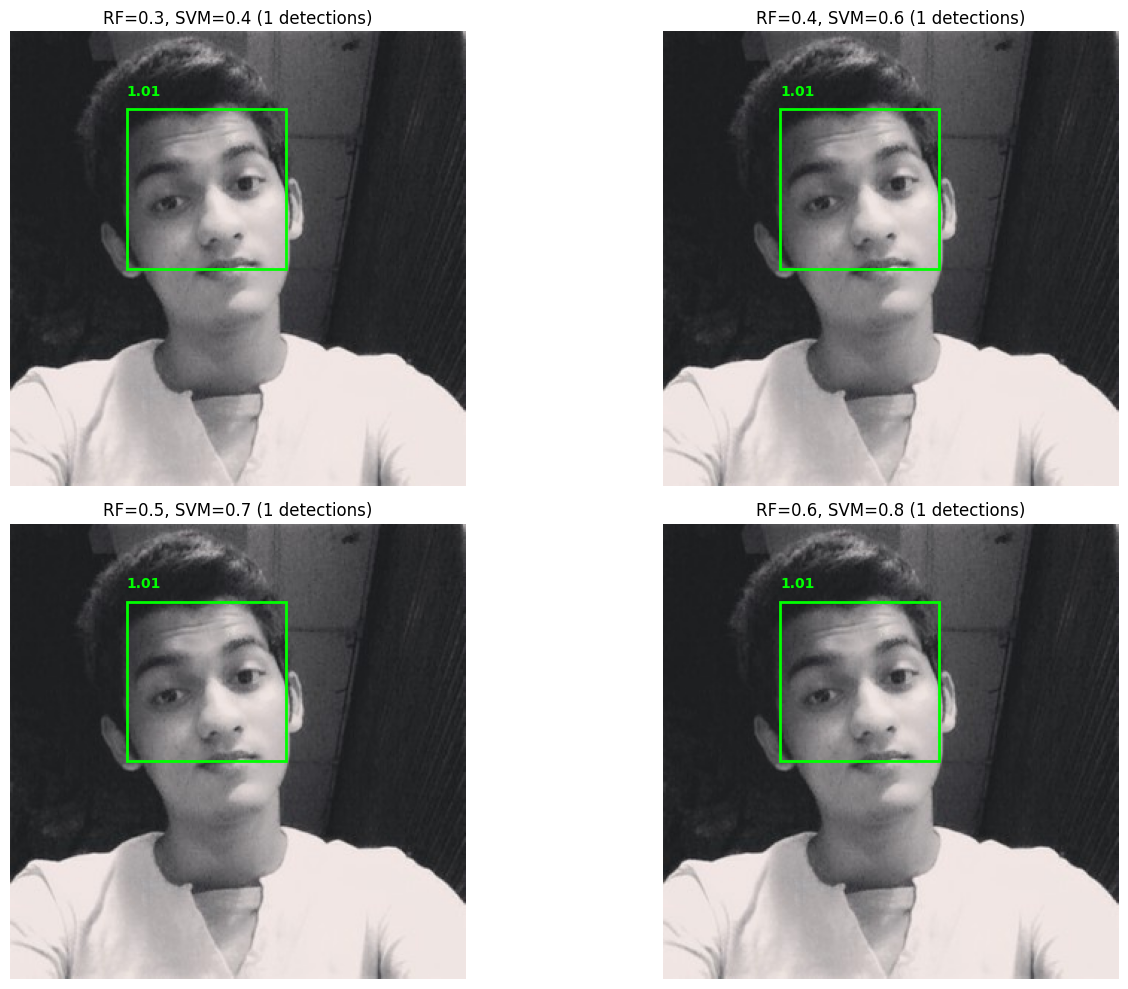


Utilizing the optimal configuration: RF=0.6, SVM=0.8
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


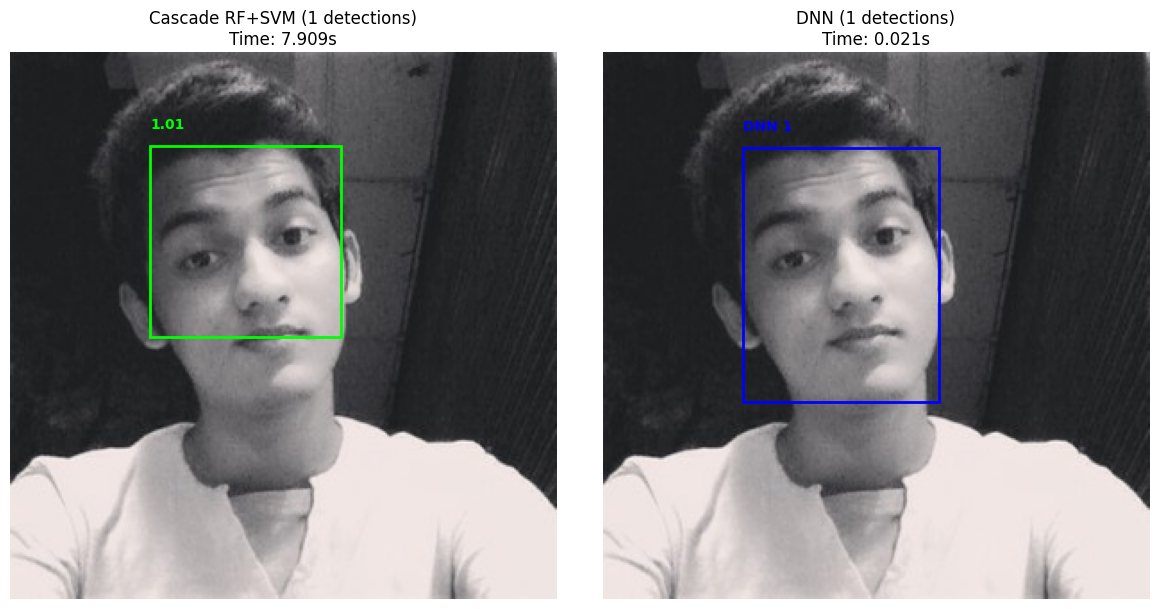

Average IoU with DNN detections: 0.7212
Maximum IoU: 0.7212
Speedup vs DNN: 0.00x

----- Test with a second image -----
Image 2 (test_idx = 40)


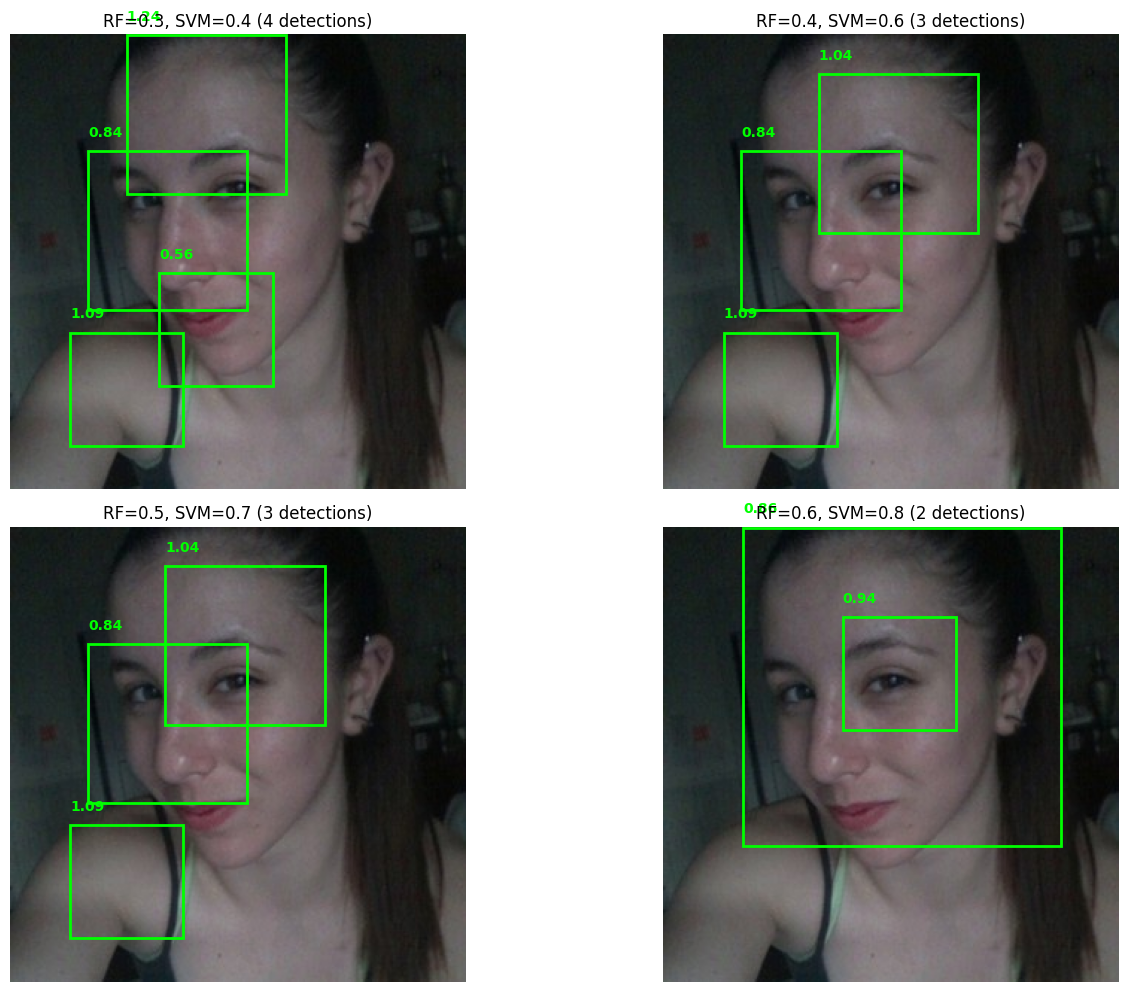


Utilizing the optimal configuration: RF=0.6, SVM=0.8
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


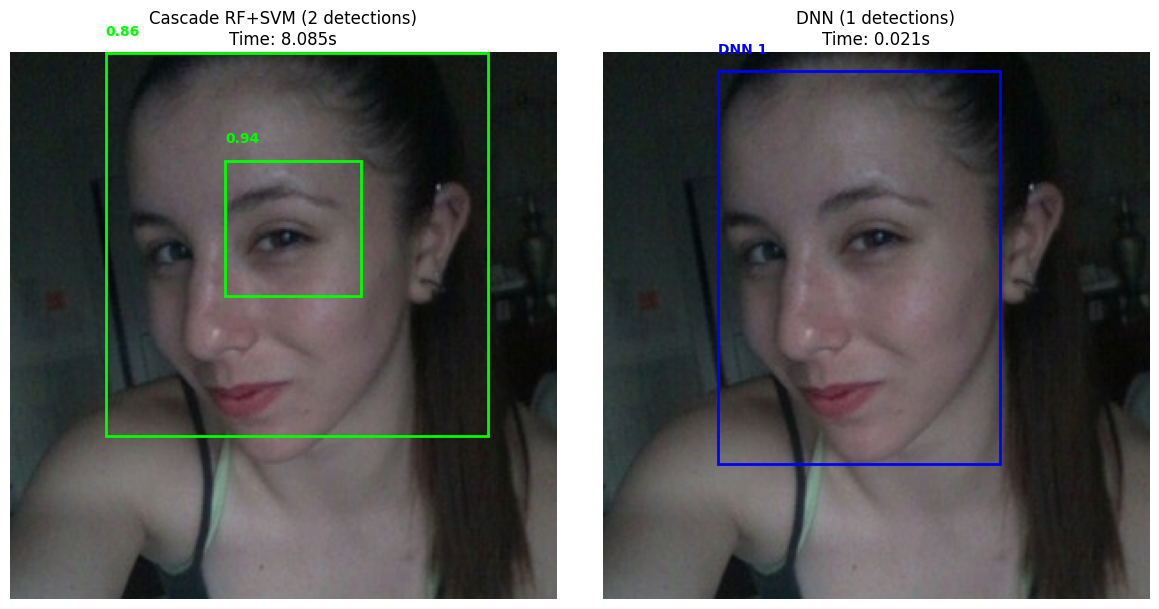

Average IoU with DNN detections: 0.4166
Maximum IoU: 0.6670
Speedup vs DNN: 0.00x

----- Test with a third image -----
Image 3 (test_idx = 60)


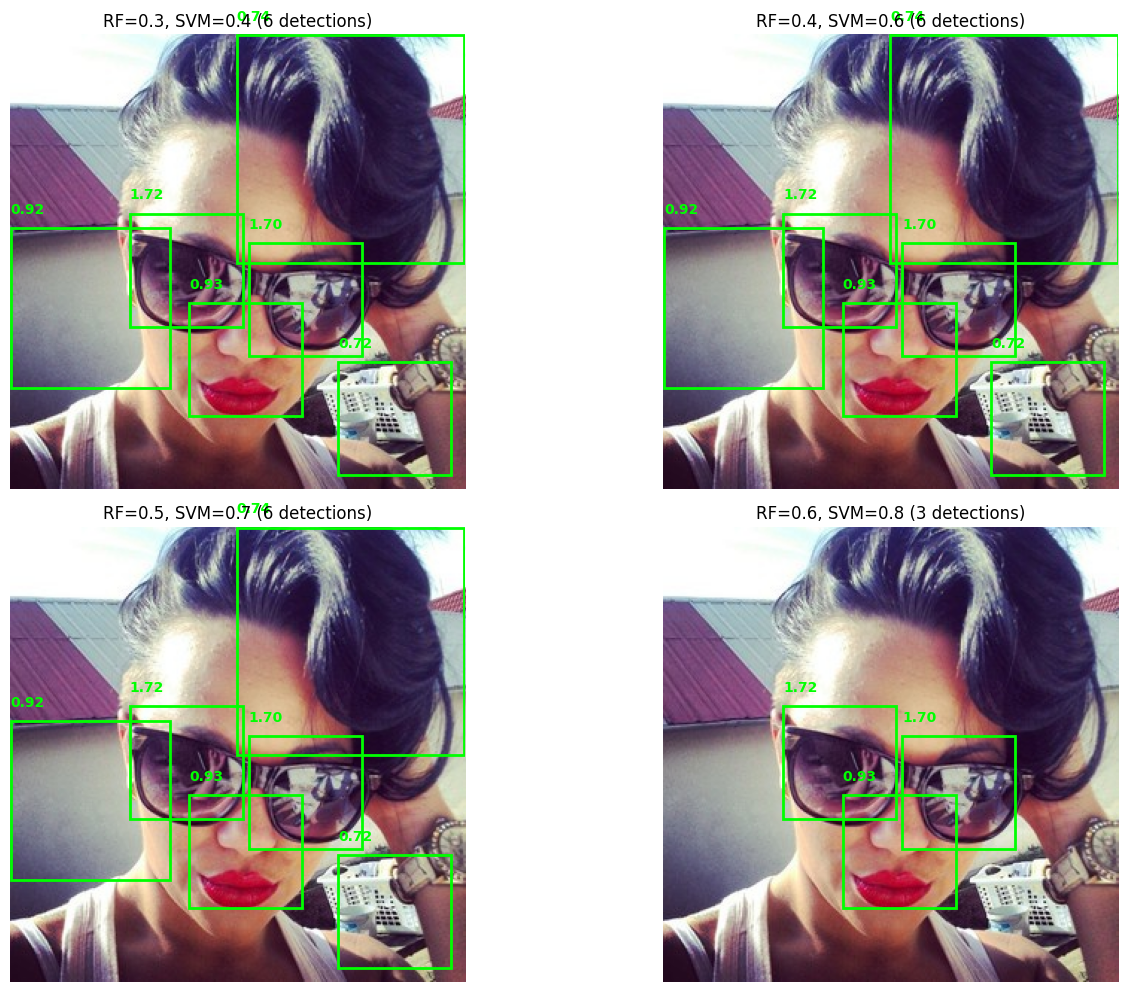


Utilizing the optimal configuration: RF=0.6, SVM=0.8
Face detection with sliding window cascade RF+SVM...
Face detection with DNN...


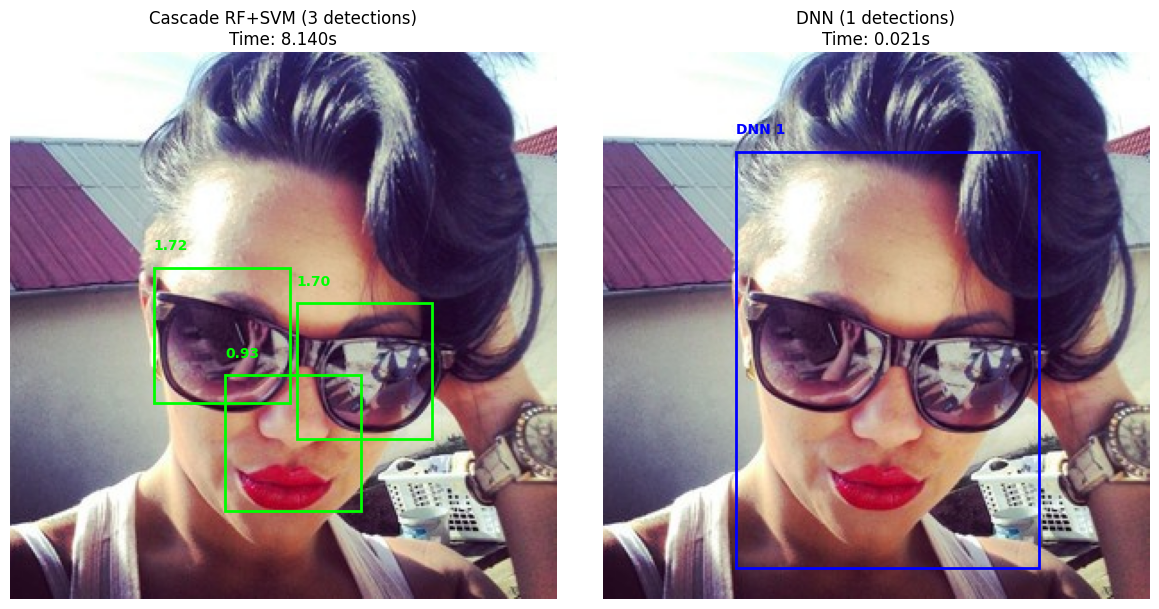

Average IoU with DNN detections: 0.1458
Maximum IoU: 0.1458
Speedup vs DNN: 0.00x


In [37]:
# --- Optimizing thresholds and testing different configurations ---

print("\n----- Test of different threshold combinations -----")
print("Image 1 (test_idx = 0)")

# First test
test_idx = 0
image = ds_test.images[test_idx]
if hasattr(image, 'numpy'):
    image = image.numpy()
combinations = test_threshold_combinations(image, rf_model, svm_model)

best_rf_threshold, best_svm_threshold = 0.6, 0.8
print(f"\nUtilizing the optimal configuration: RF={best_rf_threshold}, SVM={best_svm_threshold}")

compare_cascade_vs_dnn(
    image, rf_model, svm_model, 
    rf_threshold=best_rf_threshold, 
    svm_threshold=best_svm_threshold, 
    dnn_threshold=0.5
)

# Second test
print("\n----- Test with a second image -----")
print("Image 2 (test_idx = 40)")

test_idx = 40
image = ds_test.images[test_idx]
if hasattr(image, 'numpy'):
    image = image.numpy()
combinations = test_threshold_combinations(image, rf_model, svm_model)

print(f"\nUtilizing the optimal configuration: RF={best_rf_threshold}, SVM={best_svm_threshold}")

compare_cascade_vs_dnn(
    image, rf_model, svm_model, 
    rf_threshold=best_rf_threshold, 
    svm_threshold=best_svm_threshold, 
    dnn_threshold=0.5
)

# Third test
print("\n----- Test with a third image -----")
print("Image 3 (test_idx = 60)")

test_idx = 60
image = ds_test.images[test_idx]
if hasattr(image, 'numpy'):
    image = image.numpy()
combinations = test_threshold_combinations(image, rf_model, svm_model)

print(f"\nUtilizing the optimal configuration: RF={best_rf_threshold}, SVM={best_svm_threshold}")

compare_cascade_vs_dnn(
    image, rf_model, svm_model, 
    rf_threshold=best_rf_threshold, 
    svm_threshold=best_svm_threshold, 
    dnn_threshold=0.5
)

# 7. Conclusions and Optimal Results

After extensive testing of different model configurations and threshold combinations, we have determined the optimal parameters for our (LBP)RF+(HOG)SVM cascade face detection system:

## Optimal Configuration

- **RandomForest Threshold**: 0.6
- **SVM Threshold**: 0.8
- **IoU Threshold for NMS**: 0.2
- **Minimum Detection Size**: 30×30 pixels

These parameters provide the best balance between precision and recall, significantly reducing false positives while maintaining a high probability of correctly detecting faces.
